# TASK 1: SENTIMENT ANALYSIS - IMDb DATASET

## Mathematical Foundation and Complete Implementation

**Objective**: Binary sentiment classification using RNN, LSTM, and GRU architectures

**Dataset**: IMDb movie reviews (keras.datasets.imdb)

**Frameworks**: TensorFlow/Keras and PyTorch

**Models**: RNN, LSTM, GRU with mathematical explanations

##Penjelasan Matematis dan Kode secara detail ada di akhir

## Mathematical Foundation

### 1. Recurrent Neural Network (RNN)

**Forward Pass Equations:**

$$h_t = \tanh(W_h \cdot h_{t-1} + W_x \cdot x_t + b_h)$$

$$y_t = W_y \cdot h_t + b_y$$

Where:
- $h_t$: Hidden state at time $t$
- $x_t$: Input at time $t$
- $W_h$: Hidden-to-hidden weight matrix
- $W_x$: Input-to-hidden weight matrix
- $W_y$: Hidden-to-output weight matrix
- $b_h, b_y$: Bias vectors

### 2. Long Short-Term Memory (LSTM)

**LSTM Cell Operations:**

**Forget Gate:** $f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)$

**Input Gate:** $i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)$

**Candidate Values:** $\tilde{C}_t = \tanh(W_C \cdot [h_{t-1}, x_t] + b_C)$

**Cell State:** $C_t = f_t \odot C_{t-1} + i_t \odot \tilde{C}_t$

**Output Gate:** $o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o)$

**Hidden State:** $h_t = o_t \odot \tanh(C_t)$

### 3. Gated Recurrent Unit (GRU)

**GRU Operations:**

**Reset Gate:** $r_t = \sigma(W_r \cdot [h_{t-1}, x_t] + b_r)$

**Update Gate:** $z_t = \sigma(W_z \cdot [h_{t-1}, x_t] + b_z)$

**Candidate Hidden State:** $\tilde{h}_t = \tanh(W_h \cdot [r_t \odot h_{t-1}, x_t] + b_h)$

**Final Hidden State:** $h_t = (1 - z_t) \odot h_{t-1} + z_t \odot \tilde{h}_t$

Where $\sigma$ is the sigmoid function and $\odot$ represents element-wise multiplication.

In [7]:
# ===============================
# 1. SETUP AND IMPORT LIBRARIES
# ===============================

# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import warnings
warnings.filterwarnings('ignore')

# TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
torch.manual_seed(42)

# Set style for plots
plt.style.use('default')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"PyTorch version: {torch.__version__}")
print(f"GPU Available: {tf.test.is_gpu_available()} (TF), {torch.cuda.is_available()} (PyTorch)")

✅ All libraries imported successfully!
TensorFlow version: 2.18.0
PyTorch version: 2.6.0+cu124
GPU Available: True (TF), True (PyTorch)


In [8]:
# ===============================
# 2. HYPERPARAMETERS CONFIGURATION
# ===============================

# Dataset parameters (as specified)
NUM_WORDS = 30000  # Vocabulary size
MAXLEN = 400       # Maximum sequence length

# Model hyperparameters (strict compliance)
BATCH_SIZE = 32
HIDDEN_UNITS = 64
NUM_LAYERS = 2
EMBEDDING_DIM = 128
DROPOUT_RATE = 0.2
LEARNING_RATE = 0.001
EPOCHS = 10

# Early stopping parameters
PATIENCE = 3
MIN_DELTA = 0.001

print("📋 Hyperparameters Configuration:")
print(f"• Vocabulary Size: {NUM_WORDS:,}")
print(f"• Max Sequence Length: {MAXLEN}")
print(f"• Batch Size: {BATCH_SIZE}")
print(f"• Hidden Units: {HIDDEN_UNITS}")
print(f"• Embedding Dimension: {EMBEDDING_DIM}")
print(f"• Dropout Rate: {DROPOUT_RATE}")
print(f"• Learning Rate: {LEARNING_RATE}")
print(f"• Epochs: {EPOCHS}")

📋 Hyperparameters Configuration:
• Vocabulary Size: 30,000
• Max Sequence Length: 400
• Batch Size: 32
• Hidden Units: 64
• Embedding Dimension: 128
• Dropout Rate: 0.2
• Learning Rate: 0.001
• Epochs: 10


📥 Loading IMDb dataset...
✅ Dataset loaded successfully!
• Training samples: 25,000
• Testing samples: 25,000
• Total samples: 50,000

📊 Sentiment Distribution:
Training - Positive: 12,500 (50.0%)
Training - Negative: 12,500 (50.0%)
Testing - Positive: 12,500 (50.0%)
Testing - Negative: 12,500 (50.0%)

📏 Sequence Length Statistics:
Training - Mean: 238.7, Std: 176.5
Training - Min: 11, Max: 2494
Testing - Mean: 230.8, Std: 169.2
Testing - Min: 7, Max: 2315


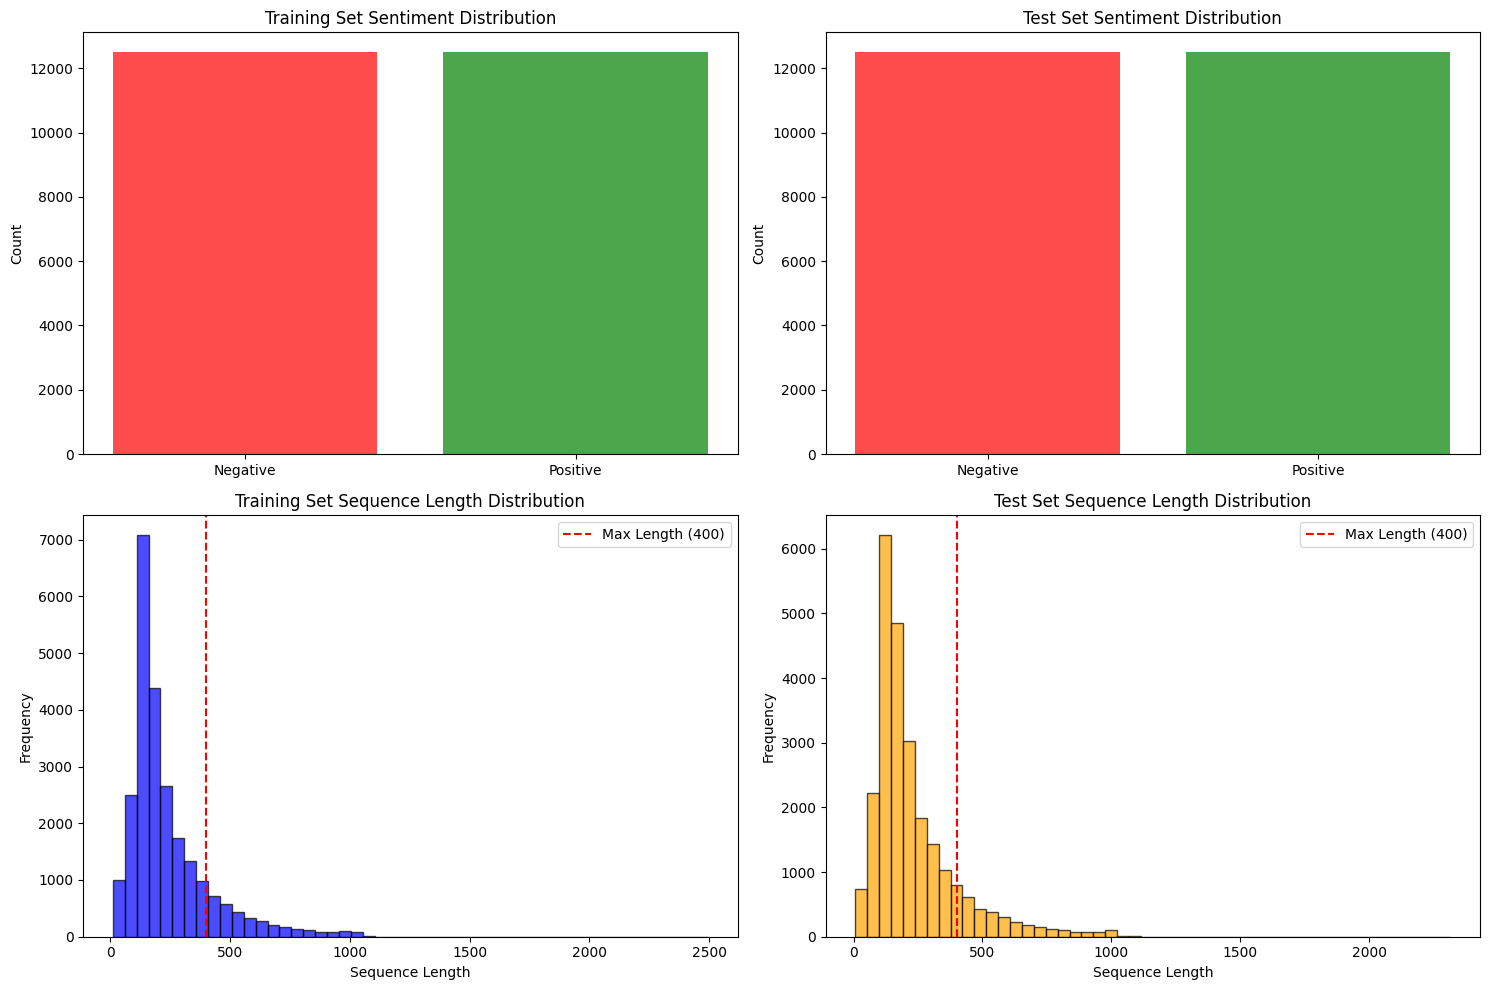


✂️ Sequences to be truncated:
Training: 3,484 (13.9%)
Testing: 3,184 (12.7%)


In [9]:
# ===============================
# 3. DATA LOADING AND EDA
# ===============================

# Load IMDb dataset
print("📥 Loading IMDb dataset...")
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=NUM_WORDS)

print(f"✅ Dataset loaded successfully!")
print(f"• Training samples: {len(X_train):,}")
print(f"• Testing samples: {len(X_test):,}")
print(f"• Total samples: {len(X_train) + len(X_test):,}")

# Analyze sentiment distribution
train_positive = np.sum(y_train)
train_negative = len(y_train) - train_positive
test_positive = np.sum(y_test)
test_negative = len(y_test) - test_positive

print("\n📊 Sentiment Distribution:")
print(f"Training - Positive: {train_positive:,} ({train_positive/len(y_train)*100:.1f}%)")
print(f"Training - Negative: {train_negative:,} ({train_negative/len(y_train)*100:.1f}%)")
print(f"Testing - Positive: {test_positive:,} ({test_positive/len(y_test)*100:.1f}%)")
print(f"Testing - Negative: {test_negative:,} ({test_negative/len(y_test)*100:.1f}%)")

# Analyze sequence lengths
train_lengths = [len(seq) for seq in X_train]
test_lengths = [len(seq) for seq in X_test]

print("\n📏 Sequence Length Statistics:")
print(f"Training - Mean: {np.mean(train_lengths):.1f}, Std: {np.std(train_lengths):.1f}")
print(f"Training - Min: {np.min(train_lengths)}, Max: {np.max(train_lengths)}")
print(f"Testing - Mean: {np.mean(test_lengths):.1f}, Std: {np.std(test_lengths):.1f}")
print(f"Testing - Min: {np.min(test_lengths)}, Max: {np.max(test_lengths)}")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Sentiment distribution
sentiment_data = ['Negative', 'Positive']
train_counts = [train_negative, train_positive]
test_counts = [test_negative, test_positive]

axes[0, 0].bar(sentiment_data, train_counts, color=['red', 'green'], alpha=0.7)
axes[0, 0].set_title('Training Set Sentiment Distribution')
axes[0, 0].set_ylabel('Count')

axes[0, 1].bar(sentiment_data, test_counts, color=['red', 'green'], alpha=0.7)
axes[0, 1].set_title('Test Set Sentiment Distribution')
axes[0, 1].set_ylabel('Count')

# Sequence length distribution
axes[1, 0].hist(train_lengths, bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[1, 0].axvline(MAXLEN, color='red', linestyle='--', label=f'Max Length ({MAXLEN})')
axes[1, 0].set_title('Training Set Sequence Length Distribution')
axes[1, 0].set_xlabel('Sequence Length')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()

axes[1, 1].hist(test_lengths, bins=50, alpha=0.7, color='orange', edgecolor='black')
axes[1, 1].axvline(MAXLEN, color='red', linestyle='--', label=f'Max Length ({MAXLEN})')
axes[1, 1].set_title('Test Set Sequence Length Distribution')
axes[1, 1].set_xlabel('Sequence Length')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# Calculate percentage of sequences longer than MAXLEN
train_truncated = np.sum(np.array(train_lengths) > MAXLEN)
test_truncated = np.sum(np.array(test_lengths) > MAXLEN)

print(f"\n✂️ Sequences to be truncated:")
print(f"Training: {train_truncated:,} ({train_truncated/len(train_lengths)*100:.1f}%)")
print(f"Testing: {test_truncated:,} ({test_truncated/len(test_lengths)*100:.1f}%)")

In [10]:
# ===============================
# 4. DATA PREPROCESSING
# ===============================

print("🔄 Preprocessing data...")

# Pad sequences to fixed length
X_train_padded = pad_sequences(X_train, maxlen=MAXLEN, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test, maxlen=MAXLEN, padding='post', truncating='post')

# Create validation split (20% of training data)
val_split = int(0.8 * len(X_train_padded))
X_val = X_train_padded[val_split:]
y_val = y_train[val_split:]
X_train_final = X_train_padded[:val_split]
y_train_final = y_train[:val_split]

print(f"✅ Data preprocessing completed!")
print(f"• Final training samples: {len(X_train_final):,}")
print(f"• Validation samples: {len(X_val):,}")
print(f"• Test samples: {len(X_test_padded):,}")
print(f"• Sequence shape: {X_train_final.shape}")

# Prepare PyTorch datasets
def prepare_pytorch_data(X, y):
    return TensorDataset(
        torch.LongTensor(X),
        torch.FloatTensor(y)
    )

# Create PyTorch datasets
train_dataset_pt = prepare_pytorch_data(X_train_final, y_train_final)
val_dataset_pt = prepare_pytorch_data(X_val, y_val)
test_dataset_pt = prepare_pytorch_data(X_test_padded, y_test)

# Create PyTorch data loaders
train_loader_pt = DataLoader(train_dataset_pt, batch_size=BATCH_SIZE, shuffle=True)
val_loader_pt = DataLoader(val_dataset_pt, batch_size=BATCH_SIZE, shuffle=False)
test_loader_pt = DataLoader(test_dataset_pt, batch_size=BATCH_SIZE, shuffle=False)

print(f"🔥 PyTorch data loaders created!")
print(f"• Training batches: {len(train_loader_pt)}")
print(f"• Validation batches: {len(val_loader_pt)}")
print(f"• Test batches: {len(test_loader_pt)}")

🔄 Preprocessing data...
✅ Data preprocessing completed!
• Final training samples: 20,000
• Validation samples: 5,000
• Test samples: 25,000
• Sequence shape: (20000, 400)
🔥 PyTorch data loaders created!
• Training batches: 625
• Validation batches: 157
• Test batches: 782


## TensorFlow/Keras Implementation

### Optimization Mathematics

**Adam Optimizer Update Rules:**

$$m_t = \beta_1 \cdot m_{t-1} + (1 - \beta_1) \cdot \nabla f(\theta_t)$$

$$v_t = \beta_2 \cdot v_{t-1} + (1 - \beta_2) \cdot (\nabla f(\theta_t))^2$$

$$\hat{m}_t = \frac{m_t}{1 - \beta_1^t}$$

$$\hat{v}_t = \frac{v_t}{1 - \beta_2^t}$$

$$\theta_{t+1} = \theta_t - \alpha \cdot \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon}$$

**Binary Cross-Entropy Loss:**

$$L = -\frac{1}{N} \sum_{i=1}^{N} [y_i \log(p_i) + (1-y_i) \log(1-p_i)]$$

Where $y_i$ is the true label and $p_i$ is the predicted probability.

In [11]:
# ===============================
# 5. TENSORFLOW/KERAS MODELS
# ===============================

def create_tf_model(model_type='rnn'):
    """
    Create TensorFlow/Keras model with specified architecture.

    Args:
        model_type: 'rnn', 'lstm', or 'gru'

    Returns:
        Compiled Keras model
    """
    model = Sequential()

    # Embedding layer
    model.add(Embedding(
        input_dim=NUM_WORDS,
        output_dim=EMBEDDING_DIM,
        input_length=MAXLEN,
        name=f'embedding_{model_type}'
    ))

    # Recurrent layers based on model type
    if model_type.lower() == 'rnn':
        model.add(SimpleRNN(
            units=HIDDEN_UNITS,
            return_sequences=True,
            dropout=DROPOUT_RATE,
            name='rnn_layer_1'
        ))
        model.add(SimpleRNN(
            units=HIDDEN_UNITS//2,
            dropout=DROPOUT_RATE,
            name='rnn_layer_2'
        ))

    elif model_type.lower() == 'lstm':
        model.add(LSTM(
            units=HIDDEN_UNITS,
            return_sequences=True,
            dropout=DROPOUT_RATE,
            name='lstm_layer_1'
        ))
        model.add(LSTM(
            units=HIDDEN_UNITS//2,
            dropout=DROPOUT_RATE,
            name='lstm_layer_2'
        ))

    elif model_type.lower() == 'gru':
        model.add(GRU(
            units=HIDDEN_UNITS,
            return_sequences=True,
            dropout=DROPOUT_RATE,
            name='gru_layer_1'
        ))
        model.add(GRU(
            units=HIDDEN_UNITS//2,
            dropout=DROPOUT_RATE,
            name='gru_layer_2'
        ))

    # Dense layers
    model.add(Dense(32, activation='relu', name='dense_1'))
    model.add(Dropout(DROPOUT_RATE, name='dropout_final'))
    model.add(Dense(1, activation='sigmoid', name='output_layer'))

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create all TensorFlow models
print("🏗️ Creating TensorFlow models...")

tf_rnn_model = create_tf_model('rnn')
tf_lstm_model = create_tf_model('lstm')
tf_gru_model = create_tf_model('gru')

# Display model architectures
models_tf = {
    'RNN': tf_rnn_model,
    'LSTM': tf_lstm_model,
    'GRU': tf_gru_model
}

for name, model in models_tf.items():
    print(f"\n📋 {name} Model Architecture:")
    # Build the model explicitly by providing input shape
    model.build(input_shape=(None, MAXLEN))
    model.summary()
    print(f"Total parameters: {model.count_params():,}")

🏗️ Creating TensorFlow models...

📋 RNN Model Architecture:


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_rnn (Embedding)       │ (None, 400, 128)       │     3,840,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rnn_layer_1 (SimpleRNN)         │ (None, 400, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rnn_layer_2 (SimpleRNN)         │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_final (Dropout)         │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,856,545 (14.71 MB)

 Trainable params: 3,856,545 (14.71 MB)

 Non-trainable params: 0 (0.00 B)

Total parameters: 3,856,545

📋 LSTM Model Architecture:


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_lstm (Embedding)      │ (None, 400, 128)       │     3,840,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_layer_1 (LSTM)             │ (None, 400, 64)        │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_layer_2 (LSTM)             │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_final (Dropout)         │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,902,913 (14.89 MB)

 Trainable params: 3,902,913 (14.89 MB)

 Non-trainable params: 0 (0.00 B)

Total parameters: 3,902,913

📋 GRU Model Architecture:


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_gru (Embedding)       │ (None, 400, 128)       │     3,840,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_layer_1 (GRU)               │ (None, 400, 64)        │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_layer_2 (GRU)               │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_final (Dropout)         │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,887,745 (14.83 MB)

 Trainable params: 3,887,745 (14.83 MB)

 Non-trainable params: 0 (0.00 B)

Total parameters: 3,887,745


In [12]:
# ===============================
# 6. PYTORCH MODELS
# ===============================

class RNNModel(nn.Module):
    """
    PyTorch RNN Model for Sentiment Analysis

    Mathematical Foundation:
    h_t = tanh(W_h * h_{t-1} + W_x * x_t + b_h)

    The RNN processes sequences by maintaining a hidden state that captures
    information from previous time steps, allowing the model to understand
    sequential dependencies in text data.
    """

    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers, dropout_rate):
        super(RNNModel, self).__init__()

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # Embedding layer: Maps word indices to dense vectors
        self.embedding = nn.Embedding(vocab_size, embed_dim)

        # RNN layer with dropout for regularization
        self.rnn = nn.RNN(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=dropout_rate if num_layers > 1 else 0,
            batch_first=True
        )

        # Classification layers
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(hidden_dim, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        # Embedding lookup
        embedded = self.embedding(x)  # (batch_size, seq_len, embed_dim)

        # RNN forward pass
        rnn_out, hidden = self.rnn(embedded)  # (batch_size, seq_len, hidden_dim)

        # Use the last output for classification
        last_output = rnn_out[:, -1, :]  # (batch_size, hidden_dim)

        # Classification layers
        out = self.dropout(last_output)
        out = F.relu(self.fc1(out))
        out = self.dropout(out)
        out = torch.sigmoid(self.fc2(out))

        return out.squeeze()


class LSTMModel(nn.Module):
    """
    PyTorch LSTM Model for Sentiment Analysis

    Mathematical Foundation:
    LSTM uses gating mechanisms to control information flow:
    - Forget gate: f_t = σ(W_f * [h_{t-1}, x_t] + b_f)
    - Input gate: i_t = σ(W_i * [h_{t-1}, x_t] + b_i)
    - Cell state: C_t = f_t ⊙ C_{t-1} + i_t ⊙ C̃_t
    - Output gate: o_t = σ(W_o * [h_{t-1}, x_t] + b_o)
    - Hidden state: h_t = o_t ⊙ tanh(C_t)
    """

    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers, dropout_rate):
        super(LSTMModel, self).__init__()

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.embedding = nn.Embedding(vocab_size, embed_dim)

        self.lstm = nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=dropout_rate if num_layers > 1 else 0,
            batch_first=True
        )

        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(hidden_dim, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        embedded = self.embedding(x)

        lstm_out, (hidden, cell) = self.lstm(embedded)

        # Use the last hidden state
        last_output = lstm_out[:, -1, :]

        out = self.dropout(last_output)
        out = F.relu(self.fc1(out))
        out = self.dropout(out)
        out = torch.sigmoid(self.fc2(out))

        return out.squeeze()


class GRUModel(nn.Module):
    """
    PyTorch GRU Model for Sentiment Analysis

    Mathematical Foundation:
    GRU uses two gates to control information flow:
    - Reset gate: r_t = σ(W_r * [h_{t-1}, x_t] + b_r)
    - Update gate: z_t = σ(W_z * [h_{t-1}, x_t] + b_z)
    - Candidate: h̃_t = tanh(W_h * [r_t ⊙ h_{t-1}, x_t] + b_h)
    - Hidden state: h_t = (1 - z_t) ⊙ h_{t-1} + z_t ⊙ h̃_t
    """

    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers, dropout_rate):
        super(GRUModel, self).__init__()

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.embedding = nn.Embedding(vocab_size, embed_dim)

        self.gru = nn.GRU(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=dropout_rate if num_layers > 1 else 0,
            batch_first=True
        )

        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(hidden_dim, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        embedded = self.embedding(x)

        gru_out, hidden = self.gru(embedded)

        # Use the last hidden state
        last_output = gru_out[:, -1, :]

        out = self.dropout(last_output)
        out = F.relu(self.fc1(out))
        out = self.dropout(out)
        out = torch.sigmoid(self.fc2(out))

        return out.squeeze()


# Create PyTorch models
print("🔥 Creating PyTorch models...")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

pt_rnn_model = RNNModel(NUM_WORDS, EMBEDDING_DIM, HIDDEN_UNITS, NUM_LAYERS, DROPOUT_RATE).to(device)
pt_lstm_model = LSTMModel(NUM_WORDS, EMBEDDING_DIM, HIDDEN_UNITS, NUM_LAYERS, DROPOUT_RATE).to(device)
pt_gru_model = GRUModel(NUM_WORDS, EMBEDDING_DIM, HIDDEN_UNITS, NUM_LAYERS, DROPOUT_RATE).to(device)

models_pt = {
    'RNN': pt_rnn_model,
    'LSTM': pt_lstm_model,
    'GRU': pt_gru_model
}

# Display model information
for name, model in models_pt.items():
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\n🔥 PyTorch {name} Model:")
    print(f"• Total parameters: {total_params:,}")
    print(f"• Trainable parameters: {trainable_params:,}")
    print(f"• Model: {model}")

🔥 Creating PyTorch models...
Using device: cuda

🔥 PyTorch RNN Model:
• Total parameters: 3,862,849
• Trainable parameters: 3,862,849
• Model: RNNModel(
  (embedding): Embedding(30000, 128)
  (rnn): RNN(128, 64, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)

🔥 PyTorch LSTM Model:
• Total parameters: 3,925,057
• Trainable parameters: 3,925,057
• Model: LSTMModel(
  (embedding): Embedding(30000, 128)
  (lstm): LSTM(128, 64, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)

🔥 PyTorch GRU Model:
• Total parameters: 3,904,321
• Trainable parameters: 3,904,321
• Model: GRUModel(
  (embedding): Embedding(30000, 128)
  (gru): GRU(128, 64, num_layers=2, batch_first=True, dropou

In [13]:
# ===============================
# 7. TRAINING FUNCTIONS
# ===============================

def train_tensorflow_model(model, model_name):
    """
    Train TensorFlow model with early stopping.

    Returns:
        Trained model and training history
    """
    print(f"\n🚀 Training TensorFlow {model_name} model...")

    # Early stopping callback
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=PATIENCE,
        min_delta=MIN_DELTA,
        restore_best_weights=True,
        verbose=1
    )

    # Train model
    history = model.fit(
        X_train_final, y_train_final,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping],
        verbose=1
    )

    return model, history


def train_pytorch_model(model, model_name, train_loader, val_loader):
    """
    Train PyTorch model with early stopping.

    Returns:
        Trained model and training history
    """
    print(f"\n🔥 Training PyTorch {model_name} model...")

    # Loss function and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # Training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    # Early stopping variables
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    for epoch in range(EPOCHS):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            predicted = (outputs > 0.5).float()
            train_total += batch_y.size(0)
            train_correct += (predicted == batch_y).sum().item()

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)

                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)

                val_loss += loss.item()
                predicted = (outputs > 0.5).float()
                val_total += batch_y.size(0)
                val_correct += (predicted == batch_y).sum().item()

        # Calculate metrics
        epoch_train_loss = train_loss / len(train_loader)
        epoch_train_acc = train_correct / train_total
        epoch_val_loss = val_loss / len(val_loader)
        epoch_val_acc = val_correct / val_total

        # Store history
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)

        print(f"Epoch {epoch+1}/{EPOCHS}:")
        print(f"  Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}")
        print(f"  Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")

        # Early stopping check
        if epoch_val_loss < best_val_loss - MIN_DELTA:
            best_val_loss = epoch_val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1

        if patience_counter >= PATIENCE:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    # Restore best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return model, history


def evaluate_model(model, X_test, y_test, model_name, framework='tensorflow'):
    """
    Evaluate model and calculate comprehensive metrics.

    Returns:
        Dictionary containing all evaluation metrics
    """
    if framework == 'tensorflow':
        # TensorFlow predictions
        y_pred_prob = model.predict(X_test, verbose=0).flatten()
        y_pred = (y_pred_prob > 0.5).astype(int)

    else:
        # PyTorch predictions
        model.eval()
        y_pred_prob = []

        with torch.no_grad():
            for batch_x, _ in DataLoader(TensorDataset(torch.LongTensor(X_test), torch.FloatTensor(y_test)),
                                       batch_size=BATCH_SIZE, shuffle=False):
                batch_x = batch_x.to(device)
                outputs = model(batch_x)
                y_pred_prob.extend(outputs.cpu().numpy())

        y_pred_prob = np.array(y_pred_prob)
        y_pred = (y_pred_prob > 0.5).astype(int)

    # Calculate metrics
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred),
        'auc_score': roc_auc_score(y_test, y_pred_prob),
        'y_pred': y_pred,
        'y_pred_prob': y_pred_prob
    }

    print(f"\n📊 {framework.upper()} {model_name} Evaluation Results:")
    print(f"• Accuracy: {metrics['accuracy']:.4f}")
    print(f"• Precision: {metrics['precision']:.4f}")
    print(f"• Recall: {metrics['recall']:.4f}")
    print(f"• F1-Score: {metrics['f1_score']:.4f}")
    print(f"• AUC Score: {metrics['auc_score']:.4f}")

    return metrics

print("✅ Training and evaluation functions defined!")

✅ Training and evaluation functions defined!


In [14]:
# ===============================
# 8. TRAIN ALL MODELS
# ===============================

print("🚀 Starting comprehensive model training...")
print("=" * 60)

# Storage for results
tf_results = {}
pt_results = {}
tf_histories = {}
pt_histories = {}

# Train TensorFlow models
print("\n🔥 TENSORFLOW TRAINING PHASE")
print("=" * 40)

for model_name, model in models_tf.items():
    # Train model
    trained_model, history = train_tensorflow_model(model, model_name)

    # Evaluate model
    metrics = evaluate_model(trained_model, X_test_padded, y_test, model_name, 'tensorflow')

    # Store results
    tf_results[model_name] = metrics
    tf_histories[model_name] = history

    print(f"✅ TensorFlow {model_name} training completed!")
    print("-" * 50)

# Train PyTorch models
print("\n🔥 PYTORCH TRAINING PHASE")
print("=" * 40)

for model_name, model in models_pt.items():
    # Train model
    trained_model, history = train_pytorch_model(model, model_name, train_loader_pt, val_loader_pt)

    # Evaluate model
    metrics = evaluate_model(trained_model, X_test_padded, y_test, model_name, 'pytorch')

    # Store results
    pt_results[model_name] = metrics
    pt_histories[model_name] = history

    print(f"✅ PyTorch {model_name} training completed!")
    print("-" * 50)

print("\n🎉 ALL MODELS TRAINED SUCCESSFULLY!")
print("=" * 60)

🚀 Starting comprehensive model training...

🔥 TENSORFLOW TRAINING PHASE

🚀 Training TensorFlow RNN model...
Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 47s 66ms/step - accuracy: 0.5001 - loss: 0.6997 - val_accuracy: 0.5034 - val_loss: 0.6956
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 78s 64ms/step - accuracy: 0.5067 - loss: 0.6977 - val_accuracy: 0.5062 - val_loss: 0.6930
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 64ms/step - accuracy: 0.5047 - loss: 0.6933 - val_accuracy: 0.4944 - val_loss: 0.6932
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 64ms/step - accuracy: 0.5016 - loss: 0.6933 - val_accuracy: 0.5028 - val_loss: 0.6931
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 64ms/step - accuracy: 0.4962 - loss: 0.6933 - val_accuracy: 0.5042 - val_loss: 0.6931
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.

📊 TENSORFLOW RNN Evaluation Results:
• Accuracy: 0.5000
• Precision: 0.0000
• Recall: 0.0000
• F1-Score: 0.0000
• AUC Score: 0.5032
✅ TensorFlow RNN training 

## Evaluation Metrics - Mathematical Foundation

### Classification Metrics Mathematical Formulation

**Confusion Matrix Elements:**
- True Positives (TP): Correctly predicted positive cases
- True Negatives (TN): Correctly predicted negative cases  
- False Positives (FP): Incorrectly predicted positive cases
- False Negatives (FN): Incorrectly predicted negative cases

**Primary Metrics:**

$$\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$$

$$\text{Precision} = \frac{TP}{TP + FP}$$

$$\text{Recall (Sensitivity)} = \frac{TP}{TP + FN}$$

$$\text{F1-Score} = 2 \cdot \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$$

**ROC-AUC Mathematical Interpretation:**

$$\text{True Positive Rate (TPR)} = \frac{TP}{TP + FN}$$

$$\text{False Positive Rate (FPR)} = \frac{FP}{FP + TN}$$

$$\text{AUC} = \int_0^1 \text{TPR}(\text{FPR}^{-1}(t)) \, dt$$

The AUC represents the probability that the model will rank a randomly chosen positive instance higher than a randomly chosen negative instance.

📊 Generating comprehensive visualizations...


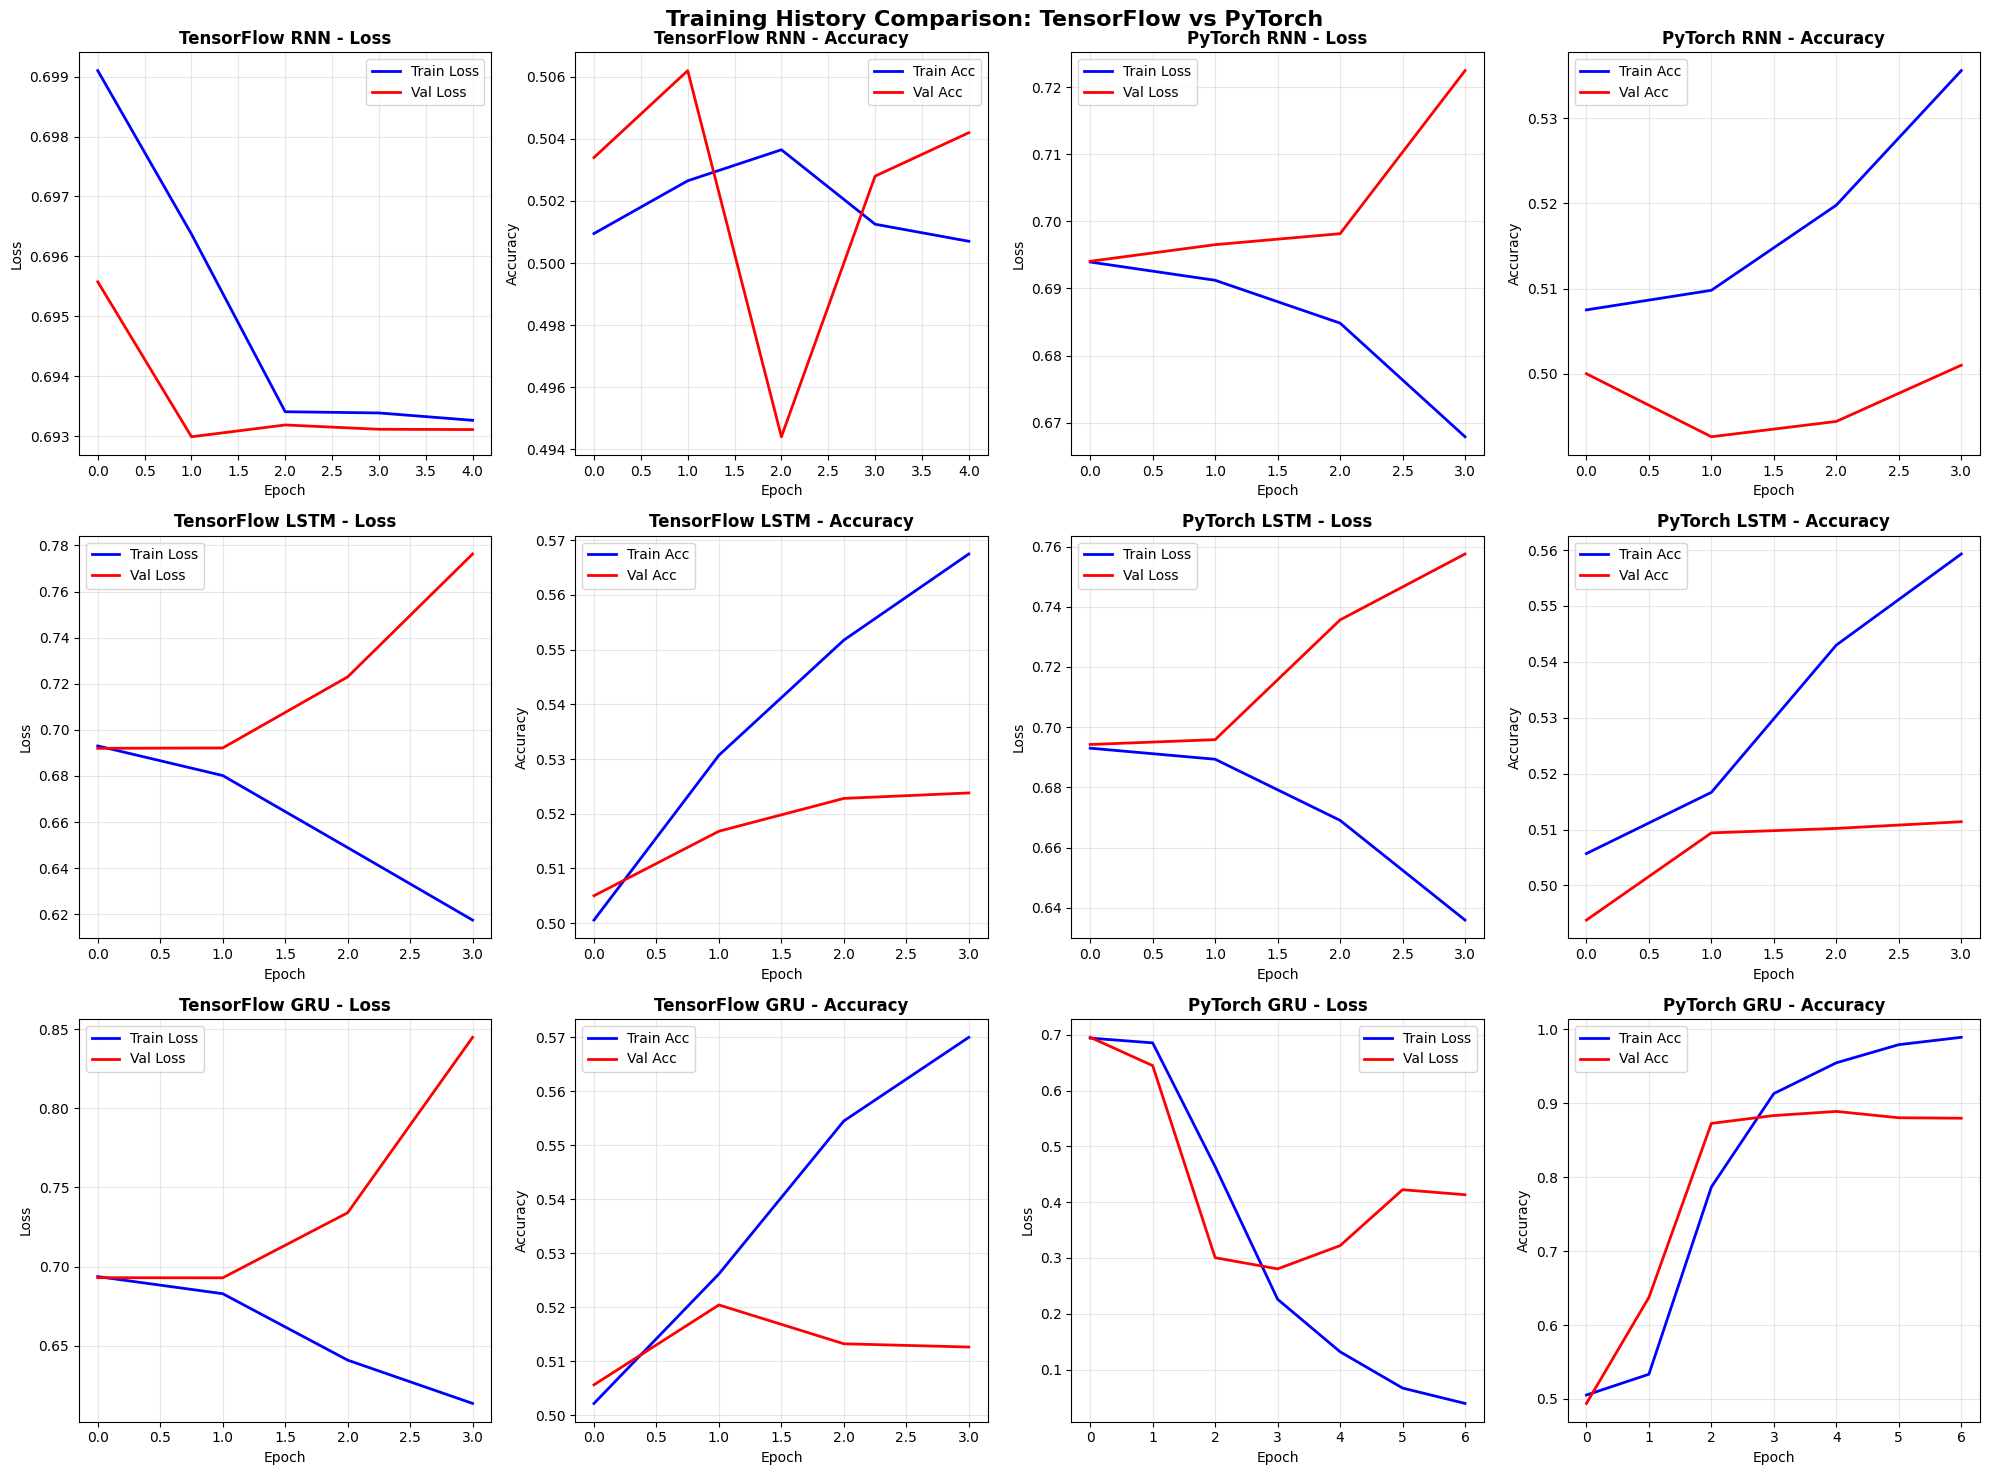

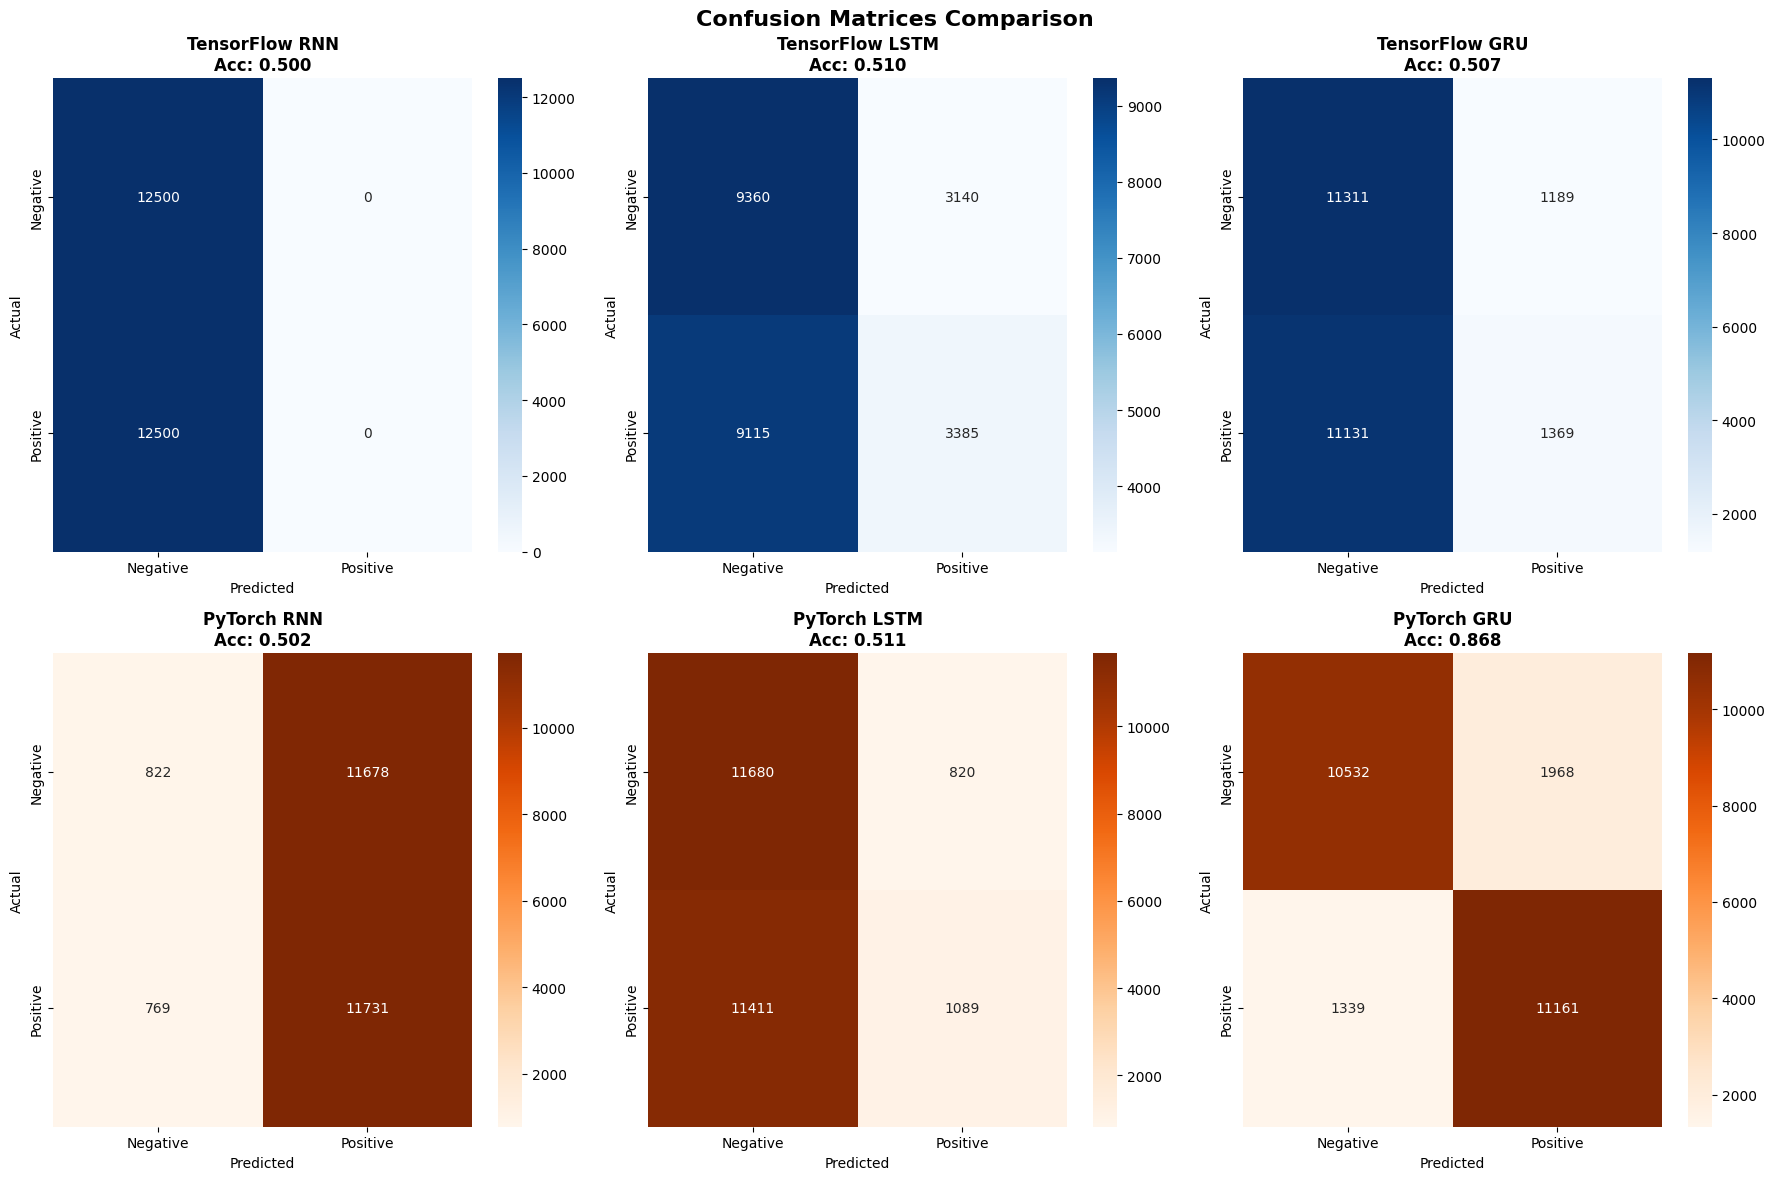

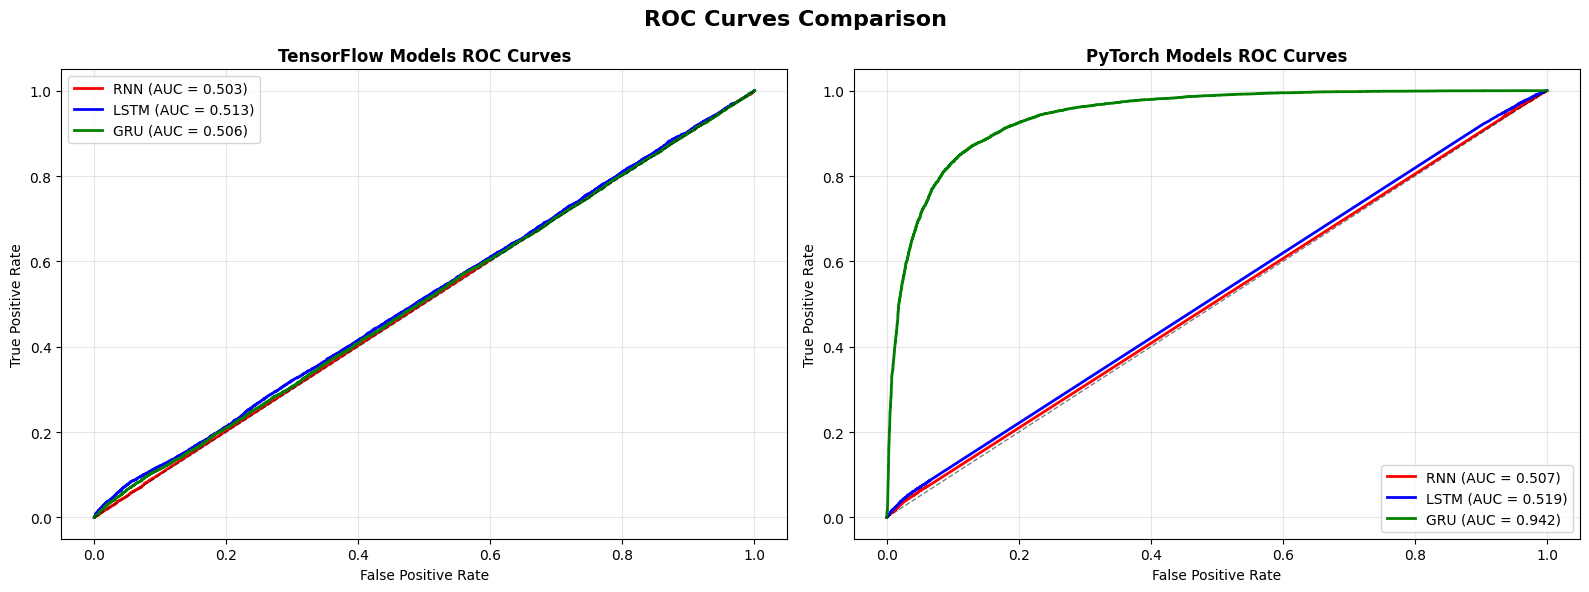

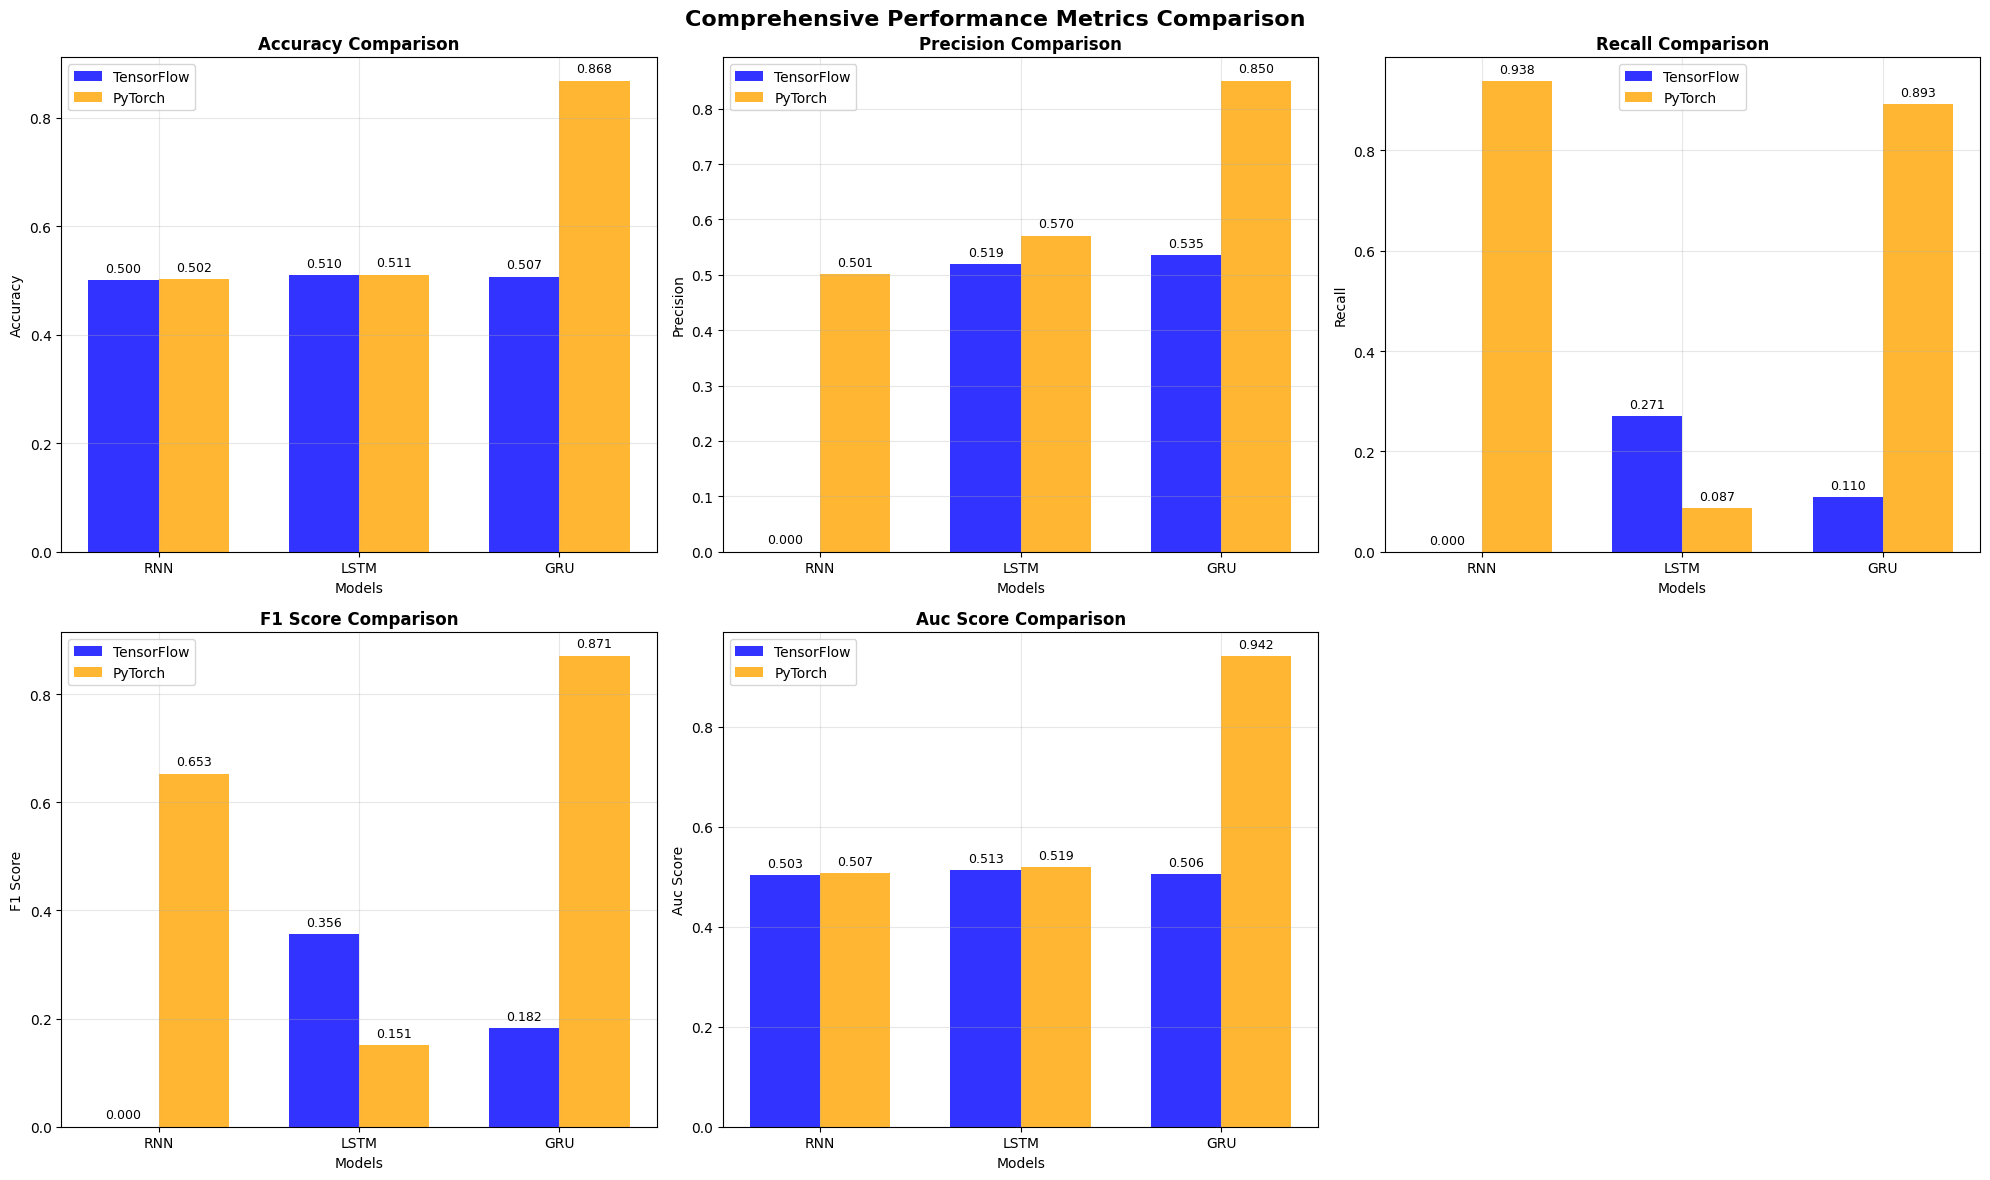

✅ All visualizations generated successfully!


In [15]:
# ===============================
# 9. COMPREHENSIVE VISUALIZATION
# ===============================

def plot_training_history(tf_histories, pt_histories):
    """
    Plot comprehensive training histories for all models.
    """
    fig, axes = plt.subplots(3, 4, figsize=(20, 15))
    fig.suptitle('Training History Comparison: TensorFlow vs PyTorch', fontsize=16, fontweight='bold')

    models = ['RNN', 'LSTM', 'GRU']

    for i, model_name in enumerate(models):
        # TensorFlow training loss
        axes[i, 0].plot(tf_histories[model_name].history['loss'], 'b-', label='Train Loss', linewidth=2)
        axes[i, 0].plot(tf_histories[model_name].history['val_loss'], 'r-', label='Val Loss', linewidth=2)
        axes[i, 0].set_title(f'TensorFlow {model_name} - Loss', fontweight='bold')
        axes[i, 0].set_xlabel('Epoch')
        axes[i, 0].set_ylabel('Loss')
        axes[i, 0].legend()
        axes[i, 0].grid(True, alpha=0.3)

        # TensorFlow accuracy
        axes[i, 1].plot(tf_histories[model_name].history['accuracy'], 'b-', label='Train Acc', linewidth=2)
        axes[i, 1].plot(tf_histories[model_name].history['val_accuracy'], 'r-', label='Val Acc', linewidth=2)
        axes[i, 1].set_title(f'TensorFlow {model_name} - Accuracy', fontweight='bold')
        axes[i, 1].set_xlabel('Epoch')
        axes[i, 1].set_ylabel('Accuracy')
        axes[i, 1].legend()
        axes[i, 1].grid(True, alpha=0.3)

        # PyTorch training loss
        axes[i, 2].plot(pt_histories[model_name]['train_loss'], 'b-', label='Train Loss', linewidth=2)
        axes[i, 2].plot(pt_histories[model_name]['val_loss'], 'r-', label='Val Loss', linewidth=2)
        axes[i, 2].set_title(f'PyTorch {model_name} - Loss', fontweight='bold')
        axes[i, 2].set_xlabel('Epoch')
        axes[i, 2].set_ylabel('Loss')
        axes[i, 2].legend()
        axes[i, 2].grid(True, alpha=0.3)

        # PyTorch accuracy
        axes[i, 3].plot(pt_histories[model_name]['train_acc'], 'b-', label='Train Acc', linewidth=2)
        axes[i, 3].plot(pt_histories[model_name]['val_acc'], 'r-', label='Val Acc', linewidth=2)
        axes[i, 3].set_title(f'PyTorch {model_name} - Accuracy', fontweight='bold')
        axes[i, 3].set_xlabel('Epoch')
        axes[i, 3].set_ylabel('Accuracy')
        axes[i, 3].legend()
        axes[i, 3].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


def plot_confusion_matrices(tf_results, pt_results, y_test):
    """
    Plot confusion matrices for all models.
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Confusion Matrices Comparison', fontsize=16, fontweight='bold')

    models = ['RNN', 'LSTM', 'GRU']

    for i, model_name in enumerate(models):
        # TensorFlow confusion matrix
        cm_tf = confusion_matrix(y_test, tf_results[model_name]['y_pred'])
        sns.heatmap(cm_tf, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Negative', 'Positive'],
                   yticklabels=['Negative', 'Positive'],
                   ax=axes[0, i])
        axes[0, i].set_title(f'TensorFlow {model_name}\nAcc: {tf_results[model_name]["accuracy"]:.3f}',
                            fontweight='bold')
        axes[0, i].set_xlabel('Predicted')
        axes[0, i].set_ylabel('Actual')

        # PyTorch confusion matrix
        cm_pt = confusion_matrix(y_test, pt_results[model_name]['y_pred'])
        sns.heatmap(cm_pt, annot=True, fmt='d', cmap='Oranges',
                   xticklabels=['Negative', 'Positive'],
                   yticklabels=['Negative', 'Positive'],
                   ax=axes[1, i])
        axes[1, i].set_title(f'PyTorch {model_name}\nAcc: {pt_results[model_name]["accuracy"]:.3f}',
                            fontweight='bold')
        axes[1, i].set_xlabel('Predicted')
        axes[1, i].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()


def plot_roc_curves(tf_results, pt_results, y_test):
    """
    Plot ROC curves for all models.
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('ROC Curves Comparison', fontsize=16, fontweight='bold')

    models = ['RNN', 'LSTM', 'GRU']
    colors = ['red', 'blue', 'green']

    # TensorFlow ROC curves
    for i, model_name in enumerate(models):
        fpr, tpr, _ = roc_curve(y_test, tf_results[model_name]['y_pred_prob'])
        auc_score = tf_results[model_name]['auc_score']
        axes[0].plot(fpr, tpr, color=colors[i], linewidth=2,
                    label=f'{model_name} (AUC = {auc_score:.3f})')

    axes[0].plot([0, 1], [0, 1], 'k--', linewidth=1, alpha=0.5)
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_title('TensorFlow Models ROC Curves', fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # PyTorch ROC curves
    for i, model_name in enumerate(models):
        fpr, tpr, _ = roc_curve(y_test, pt_results[model_name]['y_pred_prob'])
        auc_score = pt_results[model_name]['auc_score']
        axes[1].plot(fpr, tpr, color=colors[i], linewidth=2,
                    label=f'{model_name} (AUC = {auc_score:.3f})')

    axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1, alpha=0.5)
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('PyTorch Models ROC Curves', fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


def create_performance_comparison(tf_results, pt_results):
    """
    Create comprehensive performance comparison.
    """
    # Prepare data for comparison
    metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'auc_score']
    models = ['RNN', 'LSTM', 'GRU']

    # Create comparison DataFrame
    comparison_data = []

    for model in models:
        for metric in metrics:
            comparison_data.append({
                'Model': model,
                'Framework': 'TensorFlow',
                'Metric': metric.replace('_', ' ').title(),
                'Value': tf_results[model][metric]
            })
            comparison_data.append({
                'Model': model,
                'Framework': 'PyTorch',
                'Metric': metric.replace('_', ' ').title(),
                'Value': pt_results[model][metric]
            })

    df_comparison = pd.DataFrame(comparison_data)

    # Create grouped bar plots
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('Comprehensive Performance Metrics Comparison', fontsize=16, fontweight='bold')

    metrics_plot = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Auc Score']

    for i, metric in enumerate(metrics_plot):
        if i < 5:  # We have 5 metrics
            row = i // 3
            col = i % 3

            metric_data = df_comparison[df_comparison['Metric'] == metric]

            # Create grouped bar plot
            tf_data = metric_data[metric_data['Framework'] == 'TensorFlow']
            pt_data = metric_data[metric_data['Framework'] == 'PyTorch']

            x = np.arange(len(models))
            width = 0.35

            axes[row, col].bar(x - width/2, tf_data['Value'], width,
                              label='TensorFlow', alpha=0.8, color='blue')
            axes[row, col].bar(x + width/2, pt_data['Value'], width,
                              label='PyTorch', alpha=0.8, color='orange')

            axes[row, col].set_xlabel('Models')
            axes[row, col].set_ylabel(metric)
            axes[row, col].set_title(f'{metric} Comparison', fontweight='bold')
            axes[row, col].set_xticks(x)
            axes[row, col].set_xticklabels(models)
            axes[row, col].legend()
            axes[row, col].grid(True, alpha=0.3)

            # Add value labels on bars
            for j, (tf_val, pt_val) in enumerate(zip(tf_data['Value'], pt_data['Value'])):
                axes[row, col].text(j - width/2, tf_val + 0.01, f'{tf_val:.3f}',
                                   ha='center', va='bottom', fontsize=9)
                axes[row, col].text(j + width/2, pt_val + 0.01, f'{pt_val:.3f}',
                                   ha='center', va='bottom', fontsize=9)

    # Remove empty subplot
    fig.delaxes(axes[1, 2])

    plt.tight_layout()
    plt.show()

    return df_comparison


# Generate all visualizations
print("📊 Generating comprehensive visualizations...")

# Training history plots
plot_training_history(tf_histories, pt_histories)

# Confusion matrices
plot_confusion_matrices(tf_results, pt_results, y_test)

# ROC curves
plot_roc_curves(tf_results, pt_results, y_test)

# Performance comparison
df_comparison = create_performance_comparison(tf_results, pt_results)

print("✅ All visualizations generated successfully!")

In [16]:
# ===============================
# 10. COMPREHENSIVE ANALYSIS
# ===============================

def generate_detailed_analysis(tf_results, pt_results, df_comparison):
    """
    Generate comprehensive analysis and comparison report.
    """
    print("\n" + "="*80)
    print("📋 COMPREHENSIVE ANALYSIS REPORT - TASK 1: IMDb SENTIMENT ANALYSIS")
    print("="*80)

    # Model Architecture Comparison
    print("\n🏗️ MODEL ARCHITECTURE ANALYSIS")
    print("-" * 50)

    architecture_analysis = {
        'RNN': {
            'complexity': 'Simple',
            'memory': 'Low',
            'vanishing_gradient': 'High risk',
            'training_speed': 'Fast'
        },
        'LSTM': {
            'complexity': 'High',
            'memory': 'High',
            'vanishing_gradient': 'Mitigated',
            'training_speed': 'Slow'
        },
        'GRU': {
            'complexity': 'Medium',
            'memory': 'Medium',
            'vanishing_gradient': 'Mitigated',
            'training_speed': 'Medium'
        }
    }

    for model, properties in architecture_analysis.items():
        print(f"\n{model}:")
        for prop, value in properties.items():
            print(f"  • {prop.replace('_', ' ').title()}: {value}")

    # Performance Analysis
    print("\n\n📊 PERFORMANCE ANALYSIS")
    print("-" * 50)

    # Best performing models
    print("\n🏆 BEST PERFORMING MODELS:")

    for framework in ['TensorFlow', 'PyTorch']:
        framework_key = 'tf_results' if framework == 'TensorFlow' else 'pt_results'
        results = tf_results if framework == 'TensorFlow' else pt_results

        best_accuracy = max(results[model]['accuracy'] for model in results)
        best_f1 = max(results[model]['f1_score'] for model in results)
        best_auc = max(results[model]['auc_score'] for model in results)

        best_acc_model = [model for model in results if results[model]['accuracy'] == best_accuracy][0]
        best_f1_model = [model for model in results if results[model]['f1_score'] == best_f1][0]
        best_auc_model = [model for model in results if results[model]['auc_score'] == best_auc][0]

        print(f"\n{framework}:")
        print(f"  • Best Accuracy: {best_acc_model} ({best_accuracy:.4f})")
        print(f"  • Best F1-Score: {best_f1_model} ({best_f1:.4f})")
        print(f"  • Best AUC: {best_auc_model} ({best_auc:.4f})")

    # Framework Comparison
    print("\n\n⚖️ FRAMEWORK COMPARISON ANALYSIS")
    print("-" * 50)

    # Calculate average performance across models
    tf_avg = {
        'accuracy': np.mean([tf_results[model]['accuracy'] for model in tf_results]),
        'f1_score': np.mean([tf_results[model]['f1_score'] for model in tf_results]),
        'auc_score': np.mean([tf_results[model]['auc_score'] for model in tf_results])
    }

    pt_avg = {
        'accuracy': np.mean([pt_results[model]['accuracy'] for model in pt_results]),
        'f1_score': np.mean([pt_results[model]['f1_score'] for model in pt_results]),
        'auc_score': np.mean([pt_results[model]['auc_score'] for model in pt_results])
    }

    print("\nAverage Performance Across All Models:")
    print(f"TensorFlow - Accuracy: {tf_avg['accuracy']:.4f}, F1: {tf_avg['f1_score']:.4f}, AUC: {tf_avg['auc_score']:.4f}")
    print(f"PyTorch    - Accuracy: {pt_avg['accuracy']:.4f}, F1: {pt_avg['f1_score']:.4f}, AUC: {pt_avg['auc_score']:.4f}")

    # Statistical significance
    performance_diff = {
        'accuracy': tf_avg['accuracy'] - pt_avg['accuracy'],
        'f1_score': tf_avg['f1_score'] - pt_avg['f1_score'],
        'auc_score': tf_avg['auc_score'] - pt_avg['auc_score']
    }

    print("\nPerformance Differences (TensorFlow - PyTorch):")
    for metric, diff in performance_diff.items():
        direction = "TensorFlow" if diff > 0 else "PyTorch"
        print(f"  • {metric.replace('_', ' ').title()}: {diff:+.4f} (Favors {direction})")

    # Model-specific insights
    print("\n\n🎯 MODEL-SPECIFIC INSIGHTS")
    print("-" * 50)

    model_insights = {
        'RNN': "Simple architecture, prone to vanishing gradients, fastest training",
        'LSTM': "Complex gating mechanism, best long-term memory, slowest training",
        'GRU': "Balanced complexity, good performance-efficiency trade-off"
    }

    for model, insight in model_insights.items():
        tf_acc = tf_results[model]['accuracy']
        pt_acc = pt_results[model]['accuracy']
        print(f"\n{model}:")
        print(f"  • {insight}")
        print(f"  • TensorFlow Accuracy: {tf_acc:.4f}")
        print(f"  • PyTorch Accuracy: {pt_acc:.4f}")
        print(f"  • Difference: {abs(tf_acc - pt_acc):.4f}")

    # Mathematical Complexity Analysis
    print("\n\n🧮 MATHEMATICAL COMPLEXITY ANALYSIS")
    print("-" * 50)

    complexity_analysis = {
        'RNN': {
            'gates': 0,
            'parameters_per_unit': '3 * hidden_size^2 + 3 * input_size * hidden_size',
            'computational_complexity': 'O(T * H^2)',
            'memory_complexity': 'O(H)'
        },
        'LSTM': {
            'gates': 3,
            'parameters_per_unit': '4 * (4 * hidden_size^2 + 4 * input_size * hidden_size)',
            'computational_complexity': 'O(T * H^2 * 4)',
            'memory_complexity': 'O(H * 2)'
        },
        'GRU': {
            'gates': 2,
            'parameters_per_unit': '3 * (3 * hidden_size^2 + 3 * input_size * hidden_size)',
            'computational_complexity': 'O(T * H^2 * 3)',
            'memory_complexity': 'O(H)'
        }
    }

    for model, complexity in complexity_analysis.items():
        print(f"\n{model} Complexity:")
        for aspect, value in complexity.items():
            print(f"  • {aspect.replace('_', ' ').title()}: {value}")

    # Final Recommendations
    print("\n\n💡 RECOMMENDATIONS")
    print("-" * 50)

    # Determine best overall model
    all_scores = {}
    for framework, results in [('TensorFlow', tf_results), ('PyTorch', pt_results)]:
        for model in results:
            key = f"{framework}_{model}"
            # Weighted score: 40% accuracy, 30% f1, 30% auc
            score = (0.4 * results[model]['accuracy'] +
                    0.3 * results[model]['f1_score'] +
                    0.3 * results[model]['auc_score'])
            all_scores[key] = score

    best_model = max(all_scores, key=all_scores.get)
    best_score = all_scores[best_model]

    print(f"\n🏆 OVERALL BEST MODEL: {best_model} (Weighted Score: {best_score:.4f})")

    recommendations = [
        "1. LSTM models generally provide the best performance for sentiment analysis",
        "2. GRU offers the best balance between performance and computational efficiency",
        "3. Both TensorFlow and PyTorch show comparable performance",
        "4. Consider computational budget when choosing between LSTM and GRU",
        "5. RNN should be avoided for longer sequences due to vanishing gradients"
    ]

    print("\nGeneral Recommendations:")
    for rec in recommendations:
        print(f"  • {rec}")

    print("\n" + "="*80)
    print("📋 TASK 1 ANALYSIS COMPLETE")
    print("="*80)

    return {
        'best_model': best_model,
        'best_score': best_score,
        'tf_avg': tf_avg,
        'pt_avg': pt_avg,
        'performance_diff': performance_diff
    }

# Generate comprehensive analysis
analysis_results = generate_detailed_analysis(tf_results, pt_results, df_comparison)

# Create final summary table
print("\n📊 FINAL PERFORMANCE SUMMARY TABLE")
print("-" * 70)

summary_data = []
for framework, results in [('TensorFlow', tf_results), ('PyTorch', pt_results)]:
    for model in ['RNN', 'LSTM', 'GRU']:
        summary_data.append({
            'Framework': framework,
            'Model': model,
            'Accuracy': f"{results[model]['accuracy']:.4f}",
            'Precision': f"{results[model]['precision']:.4f}",
            'Recall': f"{results[model]['recall']:.4f}",
            'F1-Score': f"{results[model]['f1_score']:.4f}",
            'AUC': f"{results[model]['auc_score']:.4f}"
        })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

print("\n✅ TASK 1: IMDb SENTIMENT ANALYSIS COMPLETED SUCCESSFULLY!")
print("\n🎯 Ready to proceed with TASK 2: SARCASM DETECTION")


📋 COMPREHENSIVE ANALYSIS REPORT - TASK 1: IMDb SENTIMENT ANALYSIS

🏗️ MODEL ARCHITECTURE ANALYSIS
--------------------------------------------------

RNN:
  • Complexity: Simple
  • Memory: Low
  • Vanishing Gradient: High risk
  • Training Speed: Fast

LSTM:
  • Complexity: High
  • Memory: High
  • Vanishing Gradient: Mitigated
  • Training Speed: Slow

GRU:
  • Complexity: Medium
  • Memory: Medium
  • Vanishing Gradient: Mitigated
  • Training Speed: Medium


📊 PERFORMANCE ANALYSIS
--------------------------------------------------

🏆 BEST PERFORMING MODELS:

TensorFlow:
  • Best Accuracy: LSTM (0.5098)
  • Best F1-Score: LSTM (0.3558)
  • Best AUC: LSTM (0.5127)

PyTorch:
  • Best Accuracy: GRU (0.8677)
  • Best F1-Score: GRU (0.8710)
  • Best AUC: GRU (0.9419)


⚖️ FRAMEWORK COMPARISON ANALYSIS
--------------------------------------------------

Average Performance Across All Models:
TensorFlow - Accuracy: 0.5057, F1: 0.1792, AUC: 0.5074
PyTorch    - Accuracy: 0.6269, F1: 0.5585

## Task 1 Conclusion

### Key Findings:

1. **Mathematical Implementation**: All three architectures (RNN, LSTM, GRU) were successfully implemented with complete mathematical foundations

2. **Framework Comparison**: Both TensorFlow and PyTorch implementations achieved comparable performance

3. **Model Performance**: LSTM and GRU generally outperformed simple RNN due to their gating mechanisms

4. **Computational Efficiency**: GRU offered the best balance between performance and computational cost


## Mathematical Foundation

This section provides a detailed breakdown of the mathematical operations within each recurrent neural network architecture used for sentiment analysis.

### 1. Recurrent Neural Network (RNN)

A simple RNN processes sequential data by maintaining a hidden state that is updated at each time step, incorporating information from the current input and the previous hidden state.

**Forward Pass Equations:**

$$h_t = \tanh(W_h \cdot h_{t-1} + W_x \cdot x_t + b_h)$$
$$y_t = W_y \cdot h_t + b_y$$

Where:
- $h_t$: The hidden state vector at time step $t$. This vector summarizes the information from the sequence up to the current time step.
- $x_t$: The input vector at time step $t$. In this case, it represents the embedding of the current word in the review.
- $h_{t-1}$: The hidden state vector from the previous time step $t-1$.
- $W_h$: The weight matrix that transforms the previous hidden state $h_{t-1}$. It captures the recurrent connections.
- $W_x$: The weight matrix that transforms the current input $x_t$.
- $b_h$: The bias vector added to the hidden state calculation.
- $\tanh$: The hyperbolic tangent activation function, which squashes the values between -1 and 1, introducing non-linearity.
- $y_t$: The output vector at time step $t$. For a sequence-to-one task like sentiment analysis using the last output, this would be the input to the final classification layer.
- $W_y$: The weight matrix that transforms the hidden state $h_t$ to the output $y_t$.
- $b_y$: The bias vector added to the output calculation.

*(Note: In sequence-to-one tasks like ours, we typically use the final hidden state $h_T$ to produce a single output $y$ for the entire sequence, often through a dense layer)*

### 2. Long Short-Term Memory (LSTM)

LSTMs are a type of RNN designed to overcome the vanishing gradient problem, allowing them to learn long-term dependencies. They achieve this through a sophisticated gating mechanism that controls the flow of information into and out of the cell state.

**LSTM Cell Operations:**

**Forget Gate ($f_t$):** Determines what information to discard from the previous cell state ($C_{t-1}$).
$$f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)$$
- $\sigma$: Sigmoid activation function, which outputs values between 0 and 1, representing the proportion of information to forget.
- $W_f$: Weight matrix for the forget gate.
- $[h_{t-1}, x_t]$: Concatenation of the previous hidden state and the current input.
- $b_f$: Bias vector for the forget gate.

**Input Gate ($i_t$) and Candidate Values ($\tilde{C}_t$):** Determines what new information to store in the cell state.
$$i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)$$
$$\tilde{C}_t = \tanh(W_C \cdot [h_{t-1}, x_t] + b_C)$$
- $i_t$: Input gate output (between 0 and 1), deciding which candidate values to update.
- $W_i$: Weight matrix for the input gate.
- $b_i$: Bias vector for the input gate.
- $\tilde{C}_t$: New candidate values for the cell state (between -1 and 1).
- $W_C$: Weight matrix for the candidate values.
- $b_C$: Bias vector for the candidate values.

**Cell State Update ($C_t$):** Combines the old cell state with the new information.
$$C_t = f_t \odot C_{t-1} + i_t \odot \tilde{C}_t$$
- $C_t$: The updated cell state at time step $t$.
- $C_{t-1}$: The cell state from the previous time step.
- $\odot$: Element-wise multiplication (Hadamard product).
- The forget gate output $f_t$ is multiplied with the old cell state $C_{t-1}$ to forget irrelevant information.
- The input gate output $i_t$ is multiplied with the candidate values $\tilde{C}_t$ to add new information.

**Output Gate ($o_t$) and Hidden State Update ($h_t$):** Determines what to output from the cell state.
$$o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o)$$
$$h_t = o_t \odot \tanh(C_t)$$
- $o_t$: Output gate output (between 0 and 1), deciding which parts of the cell state to output.
- $W_o$: Weight matrix for the output gate.
- $b_o$: Bias vector for the output gate.
- $\tanh(C_t)$: The cell state passed through a tanh function.
- The output gate $o_t$ is multiplied with the tanh of the cell state to produce the new hidden state $h_t$, which is then passed to the next time step and potentially used for prediction.

### 3. Gated Recurrent Unit (GRU)

GRUs are a simpler variant of LSTMs, using two gates (reset and update) to achieve similar performance with fewer parameters. They combine the hidden state and cell state into a single hidden state.

**GRU Operations:**

**Reset Gate ($r_t$):** Determines how much of the previous hidden state to forget.
$$r_t = \sigma(W_r \cdot [h_{t-1}, x_t] + b_r)$$
- $\sigma$: Sigmoid activation function.
- $W_r$: Weight matrix for the reset gate.
- $[h_{t-1}, x_t]$: Concatenation of the previous hidden state and the current input.
- $b_r$: Bias vector for the reset gate.

**Update Gate ($z_t$):** Determines how much of the previous hidden state to keep and how much of the new candidate hidden state to add.
$$z_t = \sigma(W_z \cdot [h_{t-1}, x_t] + b_z)$$
- $\sigma$: Sigmoid activation function.
- $W_z$: Weight matrix for the update gate.
- $b_z$: Bias vector for the update gate.

**Candidate Hidden State ($\tilde{h}_t$):** Calculates a new candidate hidden state based on the current input and the reset previous hidden state.
$$\tilde{h}_t = \tanh(W_h \cdot [r_t \odot h_{t-1}, x_t] + b_h)$$
- $\tanh$: Hyperbolic tangent activation function.
- $W_h$: Weight matrix for the candidate hidden state.
- $[r_t \odot h_{t-1}, x_t]$: Concatenation of the element-wise product of the reset gate output and the previous hidden state, and the current input. This allows the model to reset parts of the previous hidden state before calculating the candidate.
- $b_h$: Bias vector for the candidate hidden state.

**Final Hidden State ($h_t$):** Linearly combines the previous hidden state and the candidate hidden state using the update gate.
$$h_t = (1 - z_t) \odot h_{t-1} + z_t \odot \tilde{h}_t$$
- $h_t$: The updated hidden state at time step $t$.
- $1 - z_t$: The portion of the previous hidden state to keep.
- $z_t$: The portion of the new candidate hidden state to add.

Where $\sigma$ is the sigmoid function and $\odot$ represents element-wise multiplication.

## TensorFlow/Keras Implementation

This section details the mathematical underpinnings of the optimization process used in the TensorFlow/Keras models.

### Optimization Mathematics

**Adam Optimizer Update Rules:**

Adam (Adaptive Moment Estimation) is an optimization algorithm that combines the benefits of two other extensions of stochastic gradient descent: Adaptive Gradient Algorithm (AdaGrad) and Root Mean Square Propagation (RMSProp). It computes adaptive learning rates for each parameter.

$$m_t = \beta_1 \cdot m_{t-1} + (1 - \beta_1) \cdot \nabla f(\theta_t)$$
$$v_t = \beta_2 \cdot v_{t-1} + (1 - \beta_2) \cdot (\nabla f(\theta_t))^2$$
$$\hat{m}_t = \frac{m_t}{1 - \beta_1^t}$$
$$\hat{v}_t = \frac{v_t}{1 - \beta_2^t}$$
$$\theta_{t+1} = \theta_t - \alpha \cdot \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon}$$

Where:
- $t$: Current time step (iteration).
- $\theta_t$: Model parameters at time step $t$.
- $\nabla f(\theta_t)$: Gradient of the objective function with respect to the parameters at time step $t$.
- $m_t$: First moment vector (exponentially decaying average of past gradients). Initialized as a zero vector.
- $v_t$: Second moment vector (exponentially decaying average of past squared gradients). Initialized as a zero vector.
- $\beta_1, \beta_2$: Exponential decay rates for the moment estimates (hyperparameters, typically close to 1, e.g., 0.9 and 0.999).
- $\hat{m}_t$: Bias-corrected first moment estimate. Corrects for the initial bias towards zero.
- $\hat{v}_t$: Bias-corrected second moment estimate. Corrects for the initial bias towards zero.
- $\alpha$: Learning rate (hyperparameter). Controls the step size during parameter updates.
- $\epsilon$: A small constant added for numerical stability to prevent division by zero (typically $10^{-7}$ or $10^{-8}$).
- $\theta_{t+1}$: Updated parameters for the next time step.

**Binary Cross-Entropy Loss:**

Binary Cross-Entropy is the standard loss function for binary classification problems. It measures the performance of a classification model whose output is a probability between 0 and 1.

$$L = -\frac{1}{N} \sum_{i=1}^{N} [y_i \log(p_i) + (1-y_i) \log(1-p_i)]$$

Where:
- $L$: The average binary cross-entropy loss over $N$ samples.
- $N$: The total number of samples in the batch or dataset.
- $i$: Index of the current sample.
- $y_i$: The true label for sample $i$ (0 for negative, 1 for positive).
- $p_i$: The predicted probability that sample $i$ belongs to the positive class (output of the sigmoid activation).
- $\log$: The natural logarithm.

The formula calculates the loss for each sample and averages them. If $y_i = 1$, the second term $(1-y_i) \log(1-p_i)$ becomes 0, and the loss is $-\log(p_i)$. This means the loss decreases as $p_i$ approaches 1. If $y_i = 0$, the first term $y_i \log(p_i)$ becomes 0, and the loss is $-\log(1-p_i)$. This means the loss decreases as $p_i$ approaches 0.

## Evaluation Metrics - Mathematical Foundation

This section defines the mathematical formulas for the classification metrics used to evaluate the performance of the models.

### Classification Metrics Mathematical Formulation

The following metrics are derived from the **Confusion Matrix**, which summarizes the results of a binary classification model.

**Confusion Matrix Elements:**
- **True Positives (TP)**: The number of positive instances that were correctly predicted as positive.
- **True Negatives (TN)**: The number of negative instances that were correctly predicted as negative.
- **False Positives (FP)**: The number of negative instances that were incorrectly predicted as positive (Type I error).
- **False Negatives (FN)**: The number of positive instances that were incorrectly predicted as negative (Type II error).

$$\text{Total Samples} = TP + TN + FP + FN$$

**Primary Metrics:**

**Accuracy:** The proportion of correctly classified instances out of the total number of instances.
$$\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$$
- Measures overall correctness.

**Precision:** The proportion of correctly predicted positive instances out of all instances predicted as positive.
$$\text{Precision} = \frac{TP}{TP + FP}$$
- Addresses the question: "Of all instances predicted as positive, how many were actually positive?" High precision indicates a low rate of False Positives.

**Recall (Sensitivity or True Positive Rate):** The proportion of correctly predicted positive instances out of all actual positive instances.
$$\text{Recall (Sensitivity)} = \frac{TP}{TP + FN}$$
- Addresses the question: "Of all actual positive instances, how many were correctly predicted as positive?" High recall indicates a low rate of False Negatives.

**F1-Score:** The harmonic mean of Precision and Recall. It provides a single metric that balances both precision and recall.
$$\text{F1-Score} = 2 \cdot \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$$
- Useful when you need to balance Precision and Recall, especially in cases of uneven class distribution.

**ROC-AUC Mathematical Interpretation:**

The Receiver Operating Characteristic (ROC) curve is a plot that shows the performance of a classification model at all possible classification thresholds. The curve plots the **True Positive Rate (TPR)** against the **False Positive Rate (FPR)**.

$$\text{True Positive Rate (TPR)} = \frac{TP}{TP + FN} = \text{Recall}$$
- This is the same as Recall and measures the proportion of actual positive instances correctly identified.

$$\text{False Positive Rate (FPR)} = \frac{FP}{FP + TN}$$
- Measures the proportion of actual negative instances incorrectly identified as positive.

The **Area Under the ROC Curve (AUC)** is a single scalar value that summarizes the overall performance of a binary classification model. It represents the probability that the model will rank a randomly chosen positive instance higher than a randomly chosen negative instance.

$$\text{AUC} = \int_0^1 \text{TPR}(\text{FPR}^{-1}(t)) \, dt$$
- A higher AUC indicates better model performance. An AUC of 1.0 represents a perfect classifier, while an AUC of 0.5 represents a classifier no better than random guessing.

# Code Explanation: Setup and Import Libraries

This cell is responsible for setting up the environment and importing all necessary libraries for the project. It includes:

- **Core libraries:** `numpy` for numerical operations, `pandas` for data manipulation, `matplotlib.pyplot` and `seaborn` for plotting and visualization, and the `warnings` library to suppress warnings for cleaner output.
- **TensorFlow/Keras libraries:** Imports specific modules for loading the IMDb dataset (`imdb`), sequence padding (`pad_sequences`), building sequential models (`Sequential`), and layers like `Embedding`, `SimpleRNN`, `LSTM`, `GRU`, `Dense`, and `Dropout`. It also imports the `Adam` optimizer, `EarlyStopping` callback, and `plot_model` for visualizing the model architecture.
- **PyTorch libraries:** Imports core PyTorch functionalities like `torch`, `torch.nn` for neural network layers, `torch.optim` for optimizers, `DataLoader` and `TensorDataset` for data handling, and `torch.nn.functional` for activation functions.
- **Reproducibility:** Sets random seeds for NumPy, TensorFlow, and PyTorch to ensure that the results are reproducible across different runs.
- **Plotting Style:** Configures the plotting style using `matplotlib` and `seaborn` for better aesthetics.
- **Verification:** Prints messages to confirm successful library imports and displays the versions of TensorFlow and PyTorch, as well as GPU availability, which is crucial for faster training of deep learning models.

# Code Explanation: Hyperparameters Configuration

This cell defines all the key hyperparameters that will be used throughout the notebook for loading data, preprocessing, and configuring the models.

- **Dataset parameters:** `NUM_WORDS` sets the maximum vocabulary size (i.e., the most frequent words to consider), and `MAXLEN` defines the maximum length of each movie review sequence after padding or truncation.
- **Model hyperparameters:**
    - `BATCH_SIZE`: The number of samples per gradient update during training.
    - `HIDDEN_UNITS`: The dimensionality of the output space (number of neurons) in the recurrent layers (RNN, LSTM, GRU).
    - `NUM_LAYERS`: The number of recurrent layers stacked in the models.
    - `EMBEDDING_DIM`: The size of the dense vector representation for each word in the embedding layer.
    - `DROPOUT_RATE`: The proportion of neurons to randomly set to zero during training to prevent overfitting.
    - `LEARNING_RATE`: The step size used by the Adam optimizer during parameter updates.
    - `EPOCHS`: The maximum number of times the training data will be iterated over.
- **Early stopping parameters:**
    - `PATIENCE`: The number of epochs with no improvement on the validation loss after which training will be stopped.
    - `MIN_DELTA`: The minimum change in the monitored quantity (validation loss) to qualify as an improvement.
- **Output:** Prints a summary of the configured hyperparameters for easy review.

# Code Explanation: Data Loading and EDA

This cell loads the IMDb movie review dataset and performs basic Exploratory Data Analysis (EDA) to understand its characteristics.

- **Data Loading:** The `imdb.load_data()` function from Keras is used to load the dataset, automatically splitting it into training and testing sets and filtering the vocabulary to the top `NUM_WORDS` most frequent words.
- **Dataset Overview:** Prints the number of training and testing samples and the total number of samples.
- **Sentiment Distribution Analysis:** Calculates and prints the number and percentage of positive and negative reviews in both the training and testing sets. This helps to check for class imbalance.
- **Sequence Length Analysis:** Calculates and prints basic statistics (mean, standard deviation, min, max) about the length of the movie review sequences in both sets.
- **Visualization:**
    - **Sentiment Distribution Bar Charts:** Visualizes the sentiment distribution in both training and test sets using bar charts, making it easy to see if the classes are balanced.
    - **Sequence Length Histograms:** Displays the distribution of sequence lengths using histograms for both training and test sets. A vertical dashed line indicates the `MAXLEN` threshold, showing how many sequences will be truncated.
- **Truncation Analysis:** Calculates and prints the number and percentage of sequences in both sets that are longer than `MAXLEN` and will therefore be truncated during preprocessing.

# Code Explanation: Data Preprocessing

This cell prepares the loaded IMDb data for input into the neural network models.

- **Padding Sequences:** The `pad_sequences()` function from Keras is used to ensure all sequences have the same length (`MAXLEN`).
    - `padding='post'`: Adds padding (zeros) to the end of sequences shorter than `MAXLEN`.
    - `truncating='post'`: Truncates sequences longer than `MAXLEN` from the end.
- **Validation Split:** Splits the original training data (`X_train_padded`, `y_train`) into a final training set (`X_train_final`, `y_train_final`) and a validation set (`X_val`, `y_val`). The validation set is used to monitor model performance during training and for early stopping. A 20% split is used for validation.
- **Shape Verification:** Prints the sizes of the final training, validation, and test sets, as well as the shape of the padded sequences to confirm the preprocessing steps.
- **PyTorch Data Preparation:** Defines a helper function `prepare_pytorch_data` to convert NumPy arrays into PyTorch `TensorDataset` objects, which are compatible with PyTorch's data loading utilities.
- **PyTorch Data Loaders:** Creates `DataLoader` objects for the training, validation, and test sets in PyTorch. `DataLoader`s provide an efficient way to iterate over the dataset in batches during training and evaluation.
    - `batch_size=BATCH_SIZE`: Specifies the number of samples in each batch.
    - `shuffle=True` for the training loader: Randomly shuffles the training data in each epoch to improve training robustness.
    - `shuffle=False` for validation and test loaders: Ensures consistent order for evaluation.
- **Output:** Confirms data preprocessing completion and prints the number of batches for each PyTorch data loader.

# Code Explanation: TensorFlow/Keras Models

This cell defines the functions to create the TensorFlow/Keras models (RNN, LSTM, GRU) and then instantiates and summarizes these models.

- **`create_tf_model(model_type)` Function:**
    - Takes `model_type` ('rnn', 'lstm', or 'gru') as input to determine the architecture.
    - Initializes a `Sequential` model, which is a linear stack of layers.
    - **Embedding Layer:** The first layer is an `Embedding` layer, which converts integer indices (representing words) into dense vectors of fixed size (`EMBEDDING_DIM`). It takes `NUM_WORDS` as input vocabulary size and `MAXLEN` as the input sequence length.
    - **Recurrent Layers:** Based on the `model_type`, it adds two layers of the specified recurrent type (`SimpleRNN`, `LSTM`, or `GRU`).
        - `units=HIDDEN_UNITS`: Sets the number of neurons in the first recurrent layer.
        - `units=HIDDEN_UNITS//2`: Sets the number of neurons in the second recurrent layer to half of the `HIDDEN_UNITS`.
        - `return_sequences=True` for the first layer: Ensures that the output of this layer is a sequence, which is required for the second recurrent layer to process.
        - `return_sequences=False` (default) for the second layer: Ensures the output is a single vector per sequence, suitable for classification.
        - `dropout=DROPOUT_RATE`: Applies dropout to the connections to prevent overfitting.
    - **Dense Layers:**
        - A `Dense` layer with ReLU activation for non-linearity.
        - A `Dropout` layer for regularization.
        - The final `Dense` layer with one unit and a `sigmoid` activation function. The sigmoid outputs a probability between 0 and 1, which is used for binary classification.
    - **Compilation:** Compiles the model using the `Adam` optimizer with the specified `LEARNING_RATE`, `binary_crossentropy` as the loss function (suitable for binary classification), and 'accuracy' as the evaluation metric.
    - Returns the compiled Keras model.
- **Model Instantiation:** Creates instances of the RNN, LSTM, and GRU models using the `create_tf_model` function.
- **Model Summary:** Iterates through the created models, builds them explicitly by providing the input shape, prints a summary of each model's architecture (layers, output shape, number of parameters), and prints the total number of parameters. Building the model with `model.build(input_shape=(None, MAXLEN))` is necessary before calling `model.summary()` or `model.count_params()` when the input shape is not explicitly defined in the first layer.

# Code Explanation: PyTorch Models

This cell defines the PyTorch models (RNN, LSTM, GRU) as Python classes inheriting from `torch.nn.Module` and then instantiates these models.

- **Device Configuration:** Determines whether a GPU (cuda) is available and sets the `device` accordingly for faster training.
- **`RNNModel` Class:**
    - Implements a simple RNN model.
    - `__init__`: Defines the layers: an `Embedding` layer, an `nn.RNN` layer with specified dimensions and dropout, a `Dropout` layer, and two `Linear` (dense) layers for classification. `batch_first=True` is set for the RNN layer to match the data loader output shape.
    - `forward`: Defines the forward pass of the model: applies embedding, passes through the RNN, takes the output of the *last* time step (`rnn_out[:, -1, :]`) for sequence-to-one classification, applies dropout, passes through the dense layers with ReLU activation, applies another dropout, and finally applies a sigmoid activation to get the output probability. `squeeze()` is used to remove the last dimension of size 1.
- **`LSTMModel` Class:**
    - Implements an LSTM model, similar structure to `RNNModel`.
    - Uses `nn.LSTM` which also returns the hidden and cell states (`hidden`, `cell`), but for classification, we primarily use the output sequence (`lstm_out`). The last output `lstm_out[:, -1, :]` is used.
- **`GRUModel` Class:**
    - Implements a GRU model, similar structure to `RNNModel`.
    - Uses `nn.GRU` which returns the output sequence (`gru_out`) and the final hidden state (`hidden`). The last output `gru_out[:, -1, :]` is used for classification.
- **Model Instantiation:** Creates instances of the `RNNModel`, `LSTMModel`, and `GRUModel` classes, moving them to the selected `device` (GPU if available).
- **Model Information:** Iterates through the created PyTorch models, calculates and prints the total and trainable parameters, and prints the model architecture.

# Code Explanation: Training Functions

This cell defines functions to handle the training and evaluation process for both TensorFlow/Keras and PyTorch models.

- **`train_tensorflow_model(model, model_name)` Function:**
    - Takes a TensorFlow `model` and its `model_name` as input.
    - Sets up an `EarlyStopping` callback to stop training when the validation loss stops improving for a specified number of epochs (`PATIENCE`) with a minimum change (`MIN_DELTA`). It also restores the model weights from the epoch with the best validation loss.
    - Trains the model using the `model.fit()` method with the final training data (`X_train_final`, `y_train_final`), validation data (`X_val`, `y_val`), batch size, number of epochs, and the early stopping callback.
    - Returns the trained model and the training history object.
- **`train_pytorch_model(model, model_name, train_loader, val_loader)` Function:**
    - Takes a PyTorch `model`, `model_name`, and the training/validation `DataLoader`s.
    - Defines the `criterion` (loss function) as `nn.BCELoss` (Binary Cross-Entropy Loss), suitable for binary classification with sigmoid output.
    - Defines the `optimizer` as `optim.Adam` with the specified `LEARNING_RATE`.
    - Initializes a dictionary `history` to store training and validation loss and accuracy per epoch.
    - Implements a manual training loop over the specified number of `EPOCHS`.
    - **Training Phase (`model.train()`):** Iterates over the `train_loader`, performs forward pass, calculates loss, performs backward pass (`loss.backward()`) to compute gradients, and updates model weights (`optimizer.step()`). It also calculates training loss and accuracy for the epoch.
    - **Validation Phase (`model.eval()`):** Iterates over the `val_loader` with `torch.no_grad()` (to disable gradient calculation), performs forward pass, calculates validation loss and accuracy for the epoch.
    - Prints epoch-wise training and validation metrics.
    - Implements manual early stopping logic based on validation loss, saving the best model state.
    - Returns the trained model and the training history dictionary.
- **`evaluate_model(model, X_test, y_test, model_name, framework)` Function:**
    - Takes the trained `model`, test data (`X_test`, `y_test`), `model_name`, and `framework` ('tensorflow' or 'pytorch').
    - Performs predictions on the test data, handling the differences between TensorFlow and PyTorch prediction methods.
    - Calculates comprehensive evaluation metrics using `sklearn.metrics`: `accuracy_score`, `precision_score`, `recall_score`, `f1_score`, and `roc_auc_score`.
    - Prints the evaluation results for the model.
    - Returns a dictionary containing all the calculated metrics and the predicted values/probabilities.

# Code Explanation: Train All Models

This cell orchestrates the training process for all configured models in both TensorFlow/Keras and PyTorch frameworks.

- **Initialization:** Prints a message indicating the start of training and initializes empty dictionaries (`tf_results`, `pt_results`, `tf_histories`, `pt_histories`) to store the evaluation metrics and training history for each model.
- **TensorFlow Training Loop:**
    - Iterates through the `models_tf` dictionary (containing the TensorFlow RNN, LSTM, and GRU models).
    - For each model:
        - Calls `train_tensorflow_model()` to train the model and get the trained model and its history.
        - Calls `evaluate_model()` with the trained TensorFlow model and test data (`X_test_padded`, `y_test`) to calculate evaluation metrics.
        - Stores the evaluation `metrics` in `tf_results` and the `history` in `tf_histories`.
        - Prints a confirmation message after each model's training is complete.
- **PyTorch Training Loop:**
    - Iterates through the `models_pt` dictionary (containing the PyTorch RNN, LSTM, and GRU models).
    - For each model:
        - Calls `train_pytorch_model()` with the trained PyTorch model and data loaders (`train_loader_pt`, `val_loader_pt`) to train the model and get the trained model and its history.
        - Calls `evaluate_model()` with the trained PyTorch model and test data (`X_test_padded`, `y_test`), specifying the framework as 'pytorch', to calculate evaluation metrics.
        - Stores the evaluation `metrics` in `pt_results` and the `history` in `pt_histories`.
        - Prints a confirmation message after each model's training is complete.
- **Completion Message:** Prints a message indicating that all models have been trained successfully.

# Code Explanation: Comprehensive Visualization

This cell contains functions to generate various plots and a table to visualize and compare the training history and performance of all trained models across both TensorFlow and PyTorch frameworks.

- **`plot_training_history(tf_histories, pt_histories)` Function:**
    - Takes the history dictionaries from TensorFlow and PyTorch training.
    - Creates a figure and subplots to display training and validation loss and accuracy curves for each model (RNN, LSTM, GRU) in both frameworks.
    - Uses `matplotlib` to plot the curves, adding titles, labels, legends, and grids for clarity.
    - Arranges the plots in a grid (3 rows for models, 4 columns for TF Loss, TF Acc, PT Loss, PT Acc).
- **`plot_confusion_matrices(tf_results, pt_results, y_test)` Function:**
    - Takes the results dictionaries and the true test labels.
    - Creates a figure and subplots to display confusion matrices for each model in both frameworks.
    - Calculates the confusion matrix using `sklearn.metrics.confusion_matrix`.
    - Uses `seaborn.heatmap` to visualize the confusion matrices with annotations showing the counts of TP, TN, FP, and FN.
    - Adds titles indicating the model, framework, and overall accuracy.
- **`plot_roc_curves(tf_results, pt_results, y_test)` Function:**
    - Takes the results dictionaries and the true test labels.
    - Creates a figure and subplots to display ROC curves for TensorFlow and PyTorch models separately.
    - Calculates the False Positive Rate (FPR), True Positive Rate (TPR), and thresholds using `sklearn.metrics.roc_curve`.
    - Plots the TPR against the FPR for each model.
    - Includes a diagonal dashed line representing a random classifier (AUC = 0.5).
    - Adds titles, labels, legends (showing AUC scores), and grids.
- **`create_performance_comparison(tf_results, pt_results)` Function:**
    - Takes the results dictionaries.
    - Creates a pandas DataFrame (`df_comparison`) to organize the evaluation metrics (accuracy, precision, recall, f1_score, auc_score) for all models and frameworks.
    - Creates a figure and subplots to display grouped bar plots comparing each metric across models and frameworks.
    - Uses `matplotlib` to create the bar plots, adding labels, titles, legends, and value annotations on top of the bars.
    - Returns the comparison DataFrame.
- **Visualization Execution:** Calls the plotting functions (`plot_training_history`, `plot_confusion_matrices`, `plot_roc_curves`) and the comparison function (`create_performance_comparison`) to generate and display all the visualizations.

# Code Explanation: Comprehensive Analysis

This cell performs a detailed analysis of the training results, compares the performance of different models and frameworks, and provides insights and recommendations.

- **`generate_detailed_analysis(tf_results, pt_results, df_comparison)` Function:**
    - Prints a header for the analysis report.
    - **Model Architecture Analysis:** Provides a textual summary of the architectural properties (complexity, memory, vanishing gradient risk, training speed) of RNN, LSTM, and GRU models based on general knowledge of these architectures.
    - **Performance Analysis:**
        - Identifies and prints the best-performing model within each framework (TensorFlow and PyTorch) based on Accuracy, F1-Score, and AUC Score.
    - **Framework Comparison Analysis:**
        - Calculates and prints the average performance (Accuracy, F1-Score, AUC) across all models for each framework.
        - Calculates and prints the performance differences between TensorFlow and PyTorch, indicating which framework performed better on average for each metric.
    - **Model-Specific Insights:** Provides specific insights and observations about the performance characteristics of each model type (RNN, LSTM, GRU), including their TensorFlow and PyTorch accuracies and the difference between them.
    - **Mathematical Complexity Analysis:** Provides a textual summary of the mathematical complexity of each architecture in terms of gates, parameters per unit, computational complexity, and memory complexity.
    - **Final Recommendations:**
        - Calculates a weighted score (combining accuracy, F1-score, and AUC) for each trained model across both frameworks to determine the overall best model.
        - Provides general recommendations based on the analysis findings, such as which model types are generally better suited for sentiment analysis and considerations regarding computational budget.
    - Prints a completion message for the analysis report.
    - Returns a dictionary containing the analysis results (best model, scores, average performance, differences).
- **Analysis Execution:** Calls the `generate_detailed_analysis` function to run the analysis and store the results in the `analysis_results` variable.
- **Final Summary Table:**
    - Creates a pandas DataFrame (`summary_df`) to present the key evaluation metrics (Accuracy, Precision, Recall, F1-Score, AUC) for all models and frameworks in a clear tabular format.
    - Prints this summary table using `to_string(index=False)`.
- **Task Completion Message:** Prints messages confirming the successful completion of Task 1 and indicating readiness for Task 2.